In [1]:
!pip install scikit-learn
!pip install -U xgboost
!pip install lightgbm
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [3]:
# Reading the CSV file 'hotel_booking.csv' into a pandas DataFrame
df = pd.read_csv('hotel_booking.csv')

In [4]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,7/1/15,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,7/1/15,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,7/2/15,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,7/2/15,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,7/3/15,Linda Hines,LHines@verizon.com,713-226-5883,************5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,Check-Out,9/6/17,Claudia Johnson,Claudia.J@yahoo.com,403-092-5582,************8647
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,Check-Out,9/7/17,Wesley Aguilar,WAguilar@xfinity.com,238-763-0612,************4333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,Check-Out,9/7/17,Mary Morales,Mary_Morales@hotmail.com,395-518-4100,************1821
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,Check-Out,9/7/17,Caroline Conley MD,MD_Caroline@comcast.net,531-528-1017,************7860


In [5]:
# Fill missing values in the 'children' column with 0
df['children'] = df['children'].fillna(0)

# Replace missing values in 'country' with "Unknown"
df['country'] = df['country'].fillna('Unknown')

# Replace missing values in 'agent' with 0 (or "No Agent")
df['agent'] = df['agent'].fillna(0)

# Check the percentage of missing values in 'company'
missing_percentage = df['company'].isnull().mean() * 100
if missing_percentage > 94:
    # Drop the column if more than 94% values are missing
    df.drop('company', axis=1, inplace=True)
else:
    # Optionally, you could handle missing values in 'company' differently if not dropping
    df['company'] = df['company'].fillna('No Company')

In [6]:
# Create a new feature 'total_nights' as the sum of weekend and weekday stay durations
# This feature represents the total number of nights stayed by the guest
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Fixing the 'arrival_date_month' column by converting it to numerical month values
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping)


In [7]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [8]:
# List of categorical columns to encode
categorical_columns = [
    'hotel', 'meal', 'market_segment', 'distribution_channel',
    'reservation_status', 'country', 'arrival_date_month',
    'customer_type', 'deposit_type'
]

# Dictionary to store LabelEncoder objects for each column
label_encoders = {}

# Iterate over each categorical column and apply label encoding
for col in categorical_columns:
    # Initialize a LabelEncoder for the column
    label_encoders[col] = LabelEncoder()
    
    # Transform the column values to encoded labels
    df[col] = label_encoders[col].fit_transform(df[col])

# After this step, all specified categorical columns will be encoded with integer values


In [9]:
# Initialize a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply Label Encoding on reserved_room_type and assigned_room_type
# Each unique room type will be mapped to an integer label
df['reserved_room_type'] = label_encoder.fit_transform(df['reserved_room_type'])
df['assigned_room_type'] = label_encoder.fit_transform(df['assigned_room_type'])

# Display the first few rows of the encoded columns to verify the results
print(df[['reserved_room_type', 'assigned_room_type']].head())

   reserved_room_type  assigned_room_type
0                   2                   2
1                   2                   2
2                   0                   2
3                   0                   0
4                   0                   0


In [10]:
# Convert date columns to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')

In [11]:
lead_time_95 = np.percentile(df['lead_time'], 95)
df['lead_time'] = np.where(df['lead_time'] > lead_time_95, lead_time_95, df['lead_time'])

In [12]:
numerical_columns = ['lead_time', 'adr', 'total_nights', 'adults', 'children', 'babies']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [13]:
non_numeric_columns_after = df.select_dtypes(include=['object']).columns
print("Non-numeric columns after encoding:", non_numeric_columns_after)


Non-numeric columns after encoding: Index(['name', 'email', 'phone-number', 'credit_card'], dtype='object')


In [14]:
# Drop irrelevant columns
df.drop(columns=['name', 'email', 'phone-number', 'credit_card'], inplace=True)
# Label Encoding for 'country'
label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])

# Convert 'reservation_status_date' to datetime and extract useful features
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_year'] = df['reservation_status_date'].dt.year
df['reservation_month'] = df['reservation_status_date'].dt.month
df['reservation_day'] = df['reservation_status_date'].dt.day
df.drop(columns=['reservation_status_date'], inplace=True)

# Check for non-numeric columns and verify dtypes
print(df.dtypes)

hotel                               int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                  int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                                int64
country                             int64
market_segment                      int64
distribution_channel                int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                  int64
assigned_room_type                  int64
booking_changes                     int64
deposit_type                        int64
agent                             

In [15]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'total_nights', 'reservation_year',
       'reservation_month', 'reservation_day'],
      dtype='object')

In [16]:
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
               hotel    is_canceled     lead_time  arrival_date_year  \
count  119390.000000  119390.000000  1.193900e+05      119390.000000   
mean        0.335539       0.370416 -3.999369e-17        2016.156554   
std         0.472181       0.482918  1.000004e+00           0.707476   
min         0.000000       0.000000 -1.039088e+00        2015.000000   
25%         0.000000       0.000000 -8.527265e-01        2016.000000   
50%         0.000000       0.000000 -3.247037e-01        2016.000000   
75%         1.000000       1.000000  6.174548e-01        2017.000000   
max         1.000000       1.000000  2.273997e+00        2017.000000   

       arrival_date_month  arrival_date_week_number  \
count       119390.000000             119390.000000   
mean             5.552483                 27.165173   
std              3.090619                 13.605138   
min              0.000000                  1.000000   
25%              3.000000                 16.000000   
5

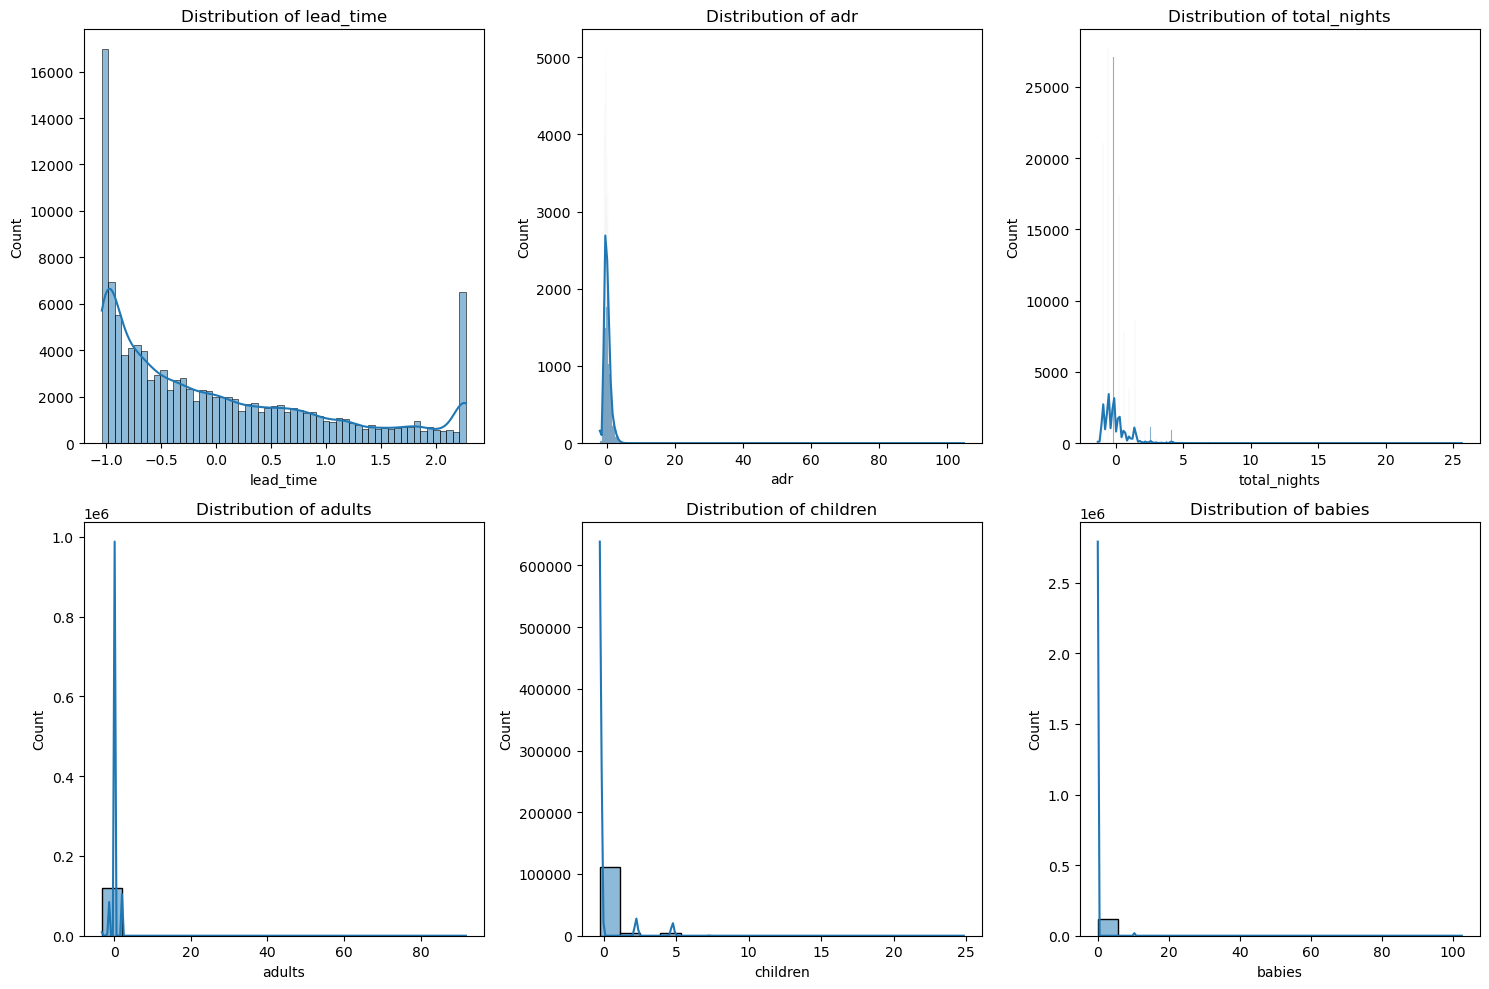

In [17]:
# Visualizing the Data Distribution for Numerical Features
plt.figure(figsize=(15, 10))
for i, column in enumerate(['lead_time', 'adr', 'total_nights', 'adults', 'children', 'babies']):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

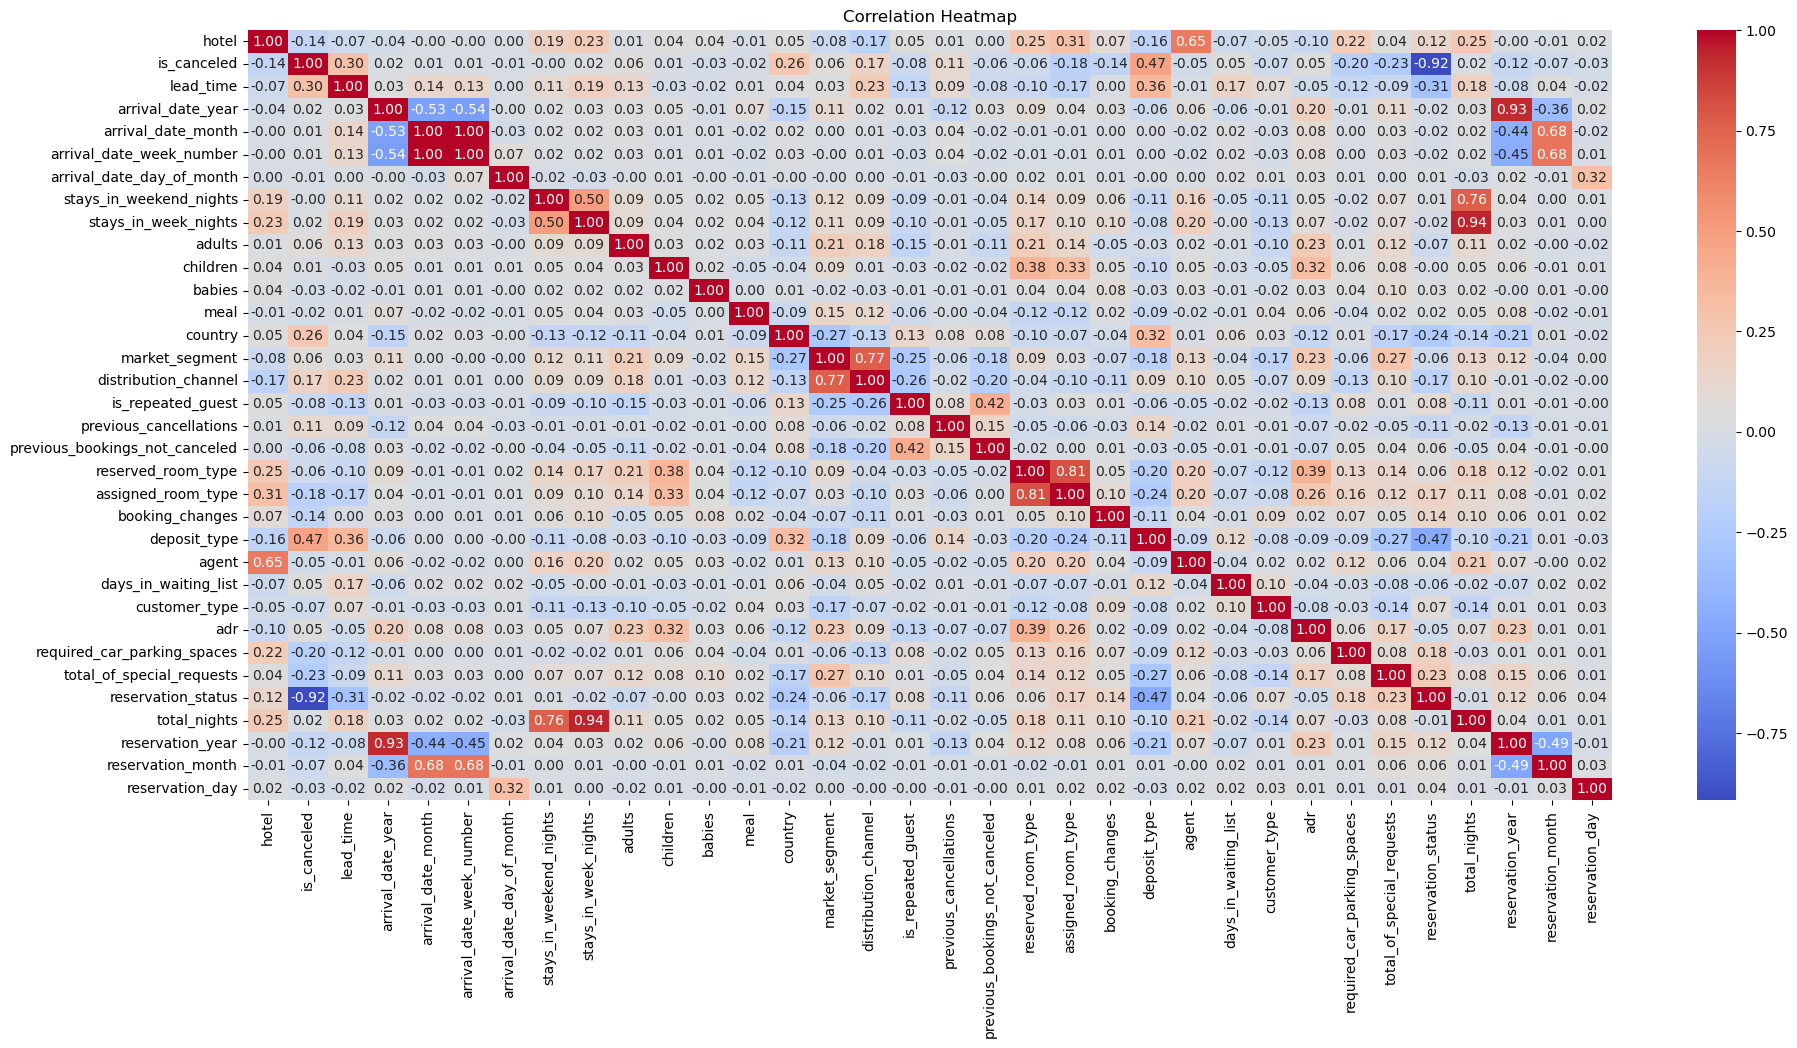

In [18]:
# Correlation Matrix and Heatmap
plt.figure(figsize=(22,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

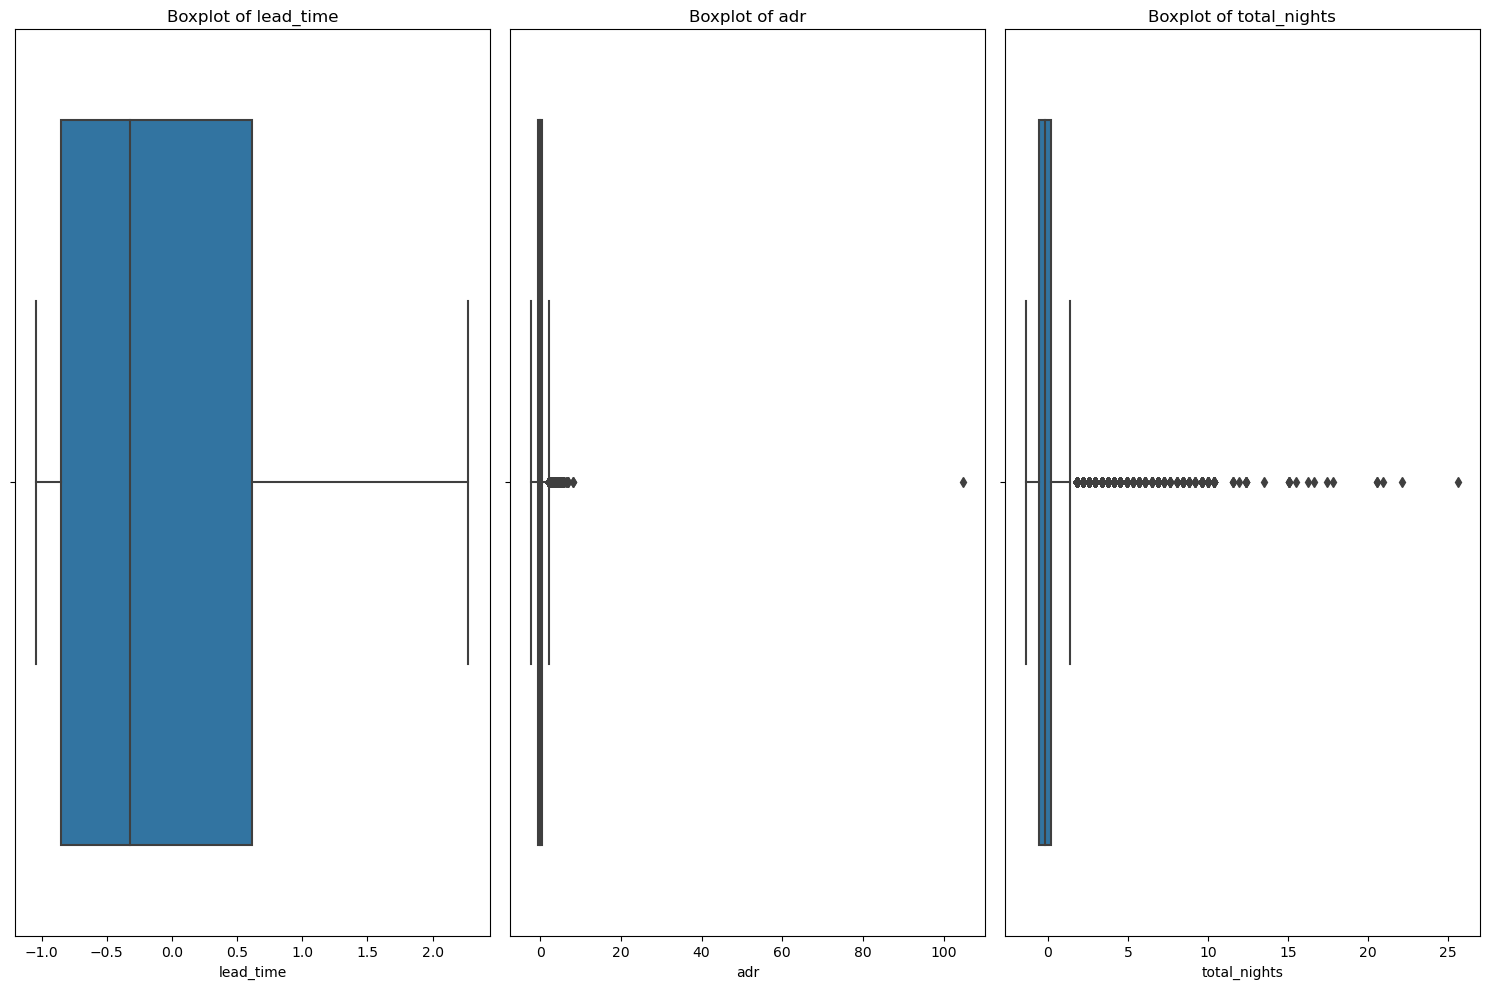

In [19]:
# Boxplots for Outliers Detection
plt.figure(figsize=(15, 10))
for i, column in enumerate(['lead_time', 'adr', 'total_nights']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

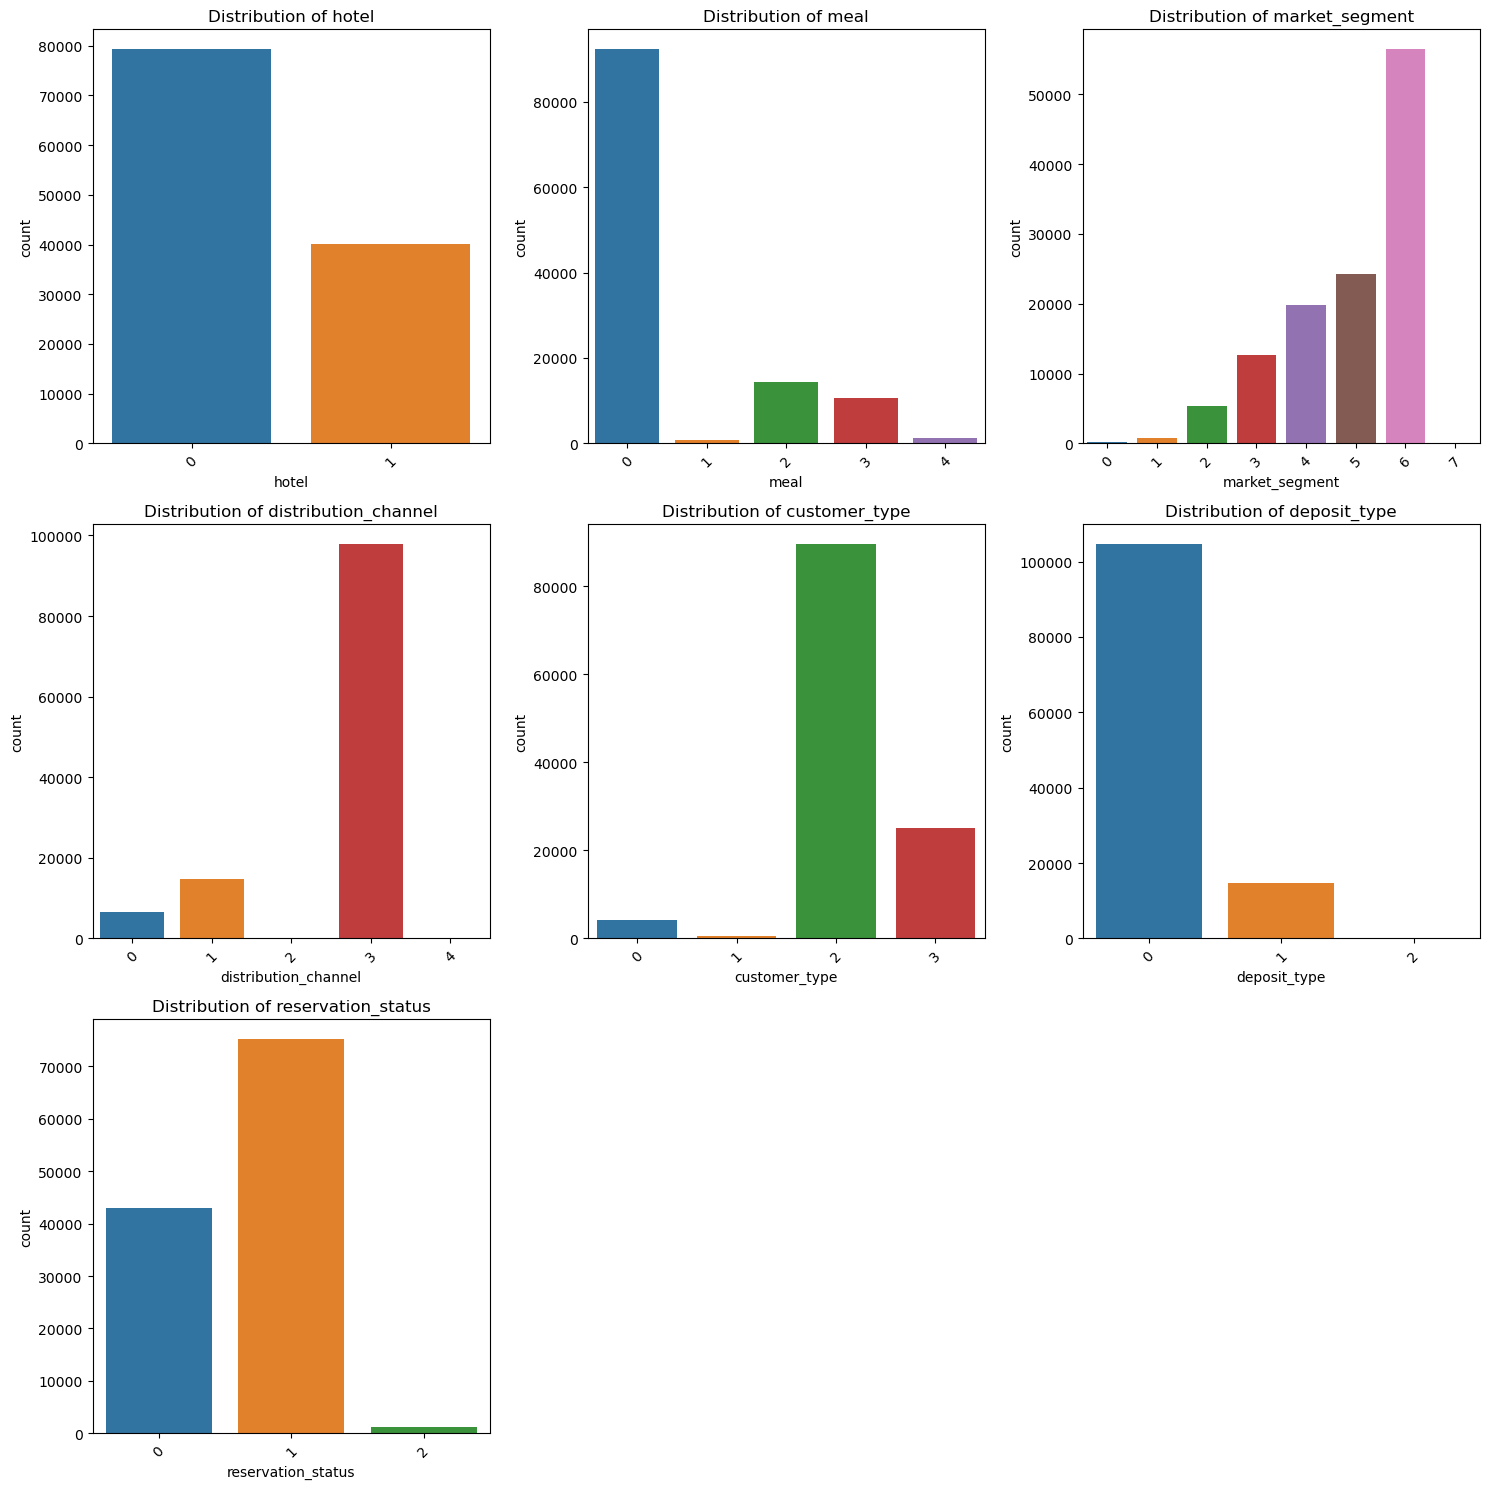

In [20]:
# Categorical Feature Distributions
categorical_columns = ['hotel', 'meal', 'market_segment', 'distribution_channel', 
                       'customer_type', 'deposit_type', 'reservation_status']
plt.figure(figsize=(15, 15))
for i, column in enumerate(categorical_columns):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=df[column])
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

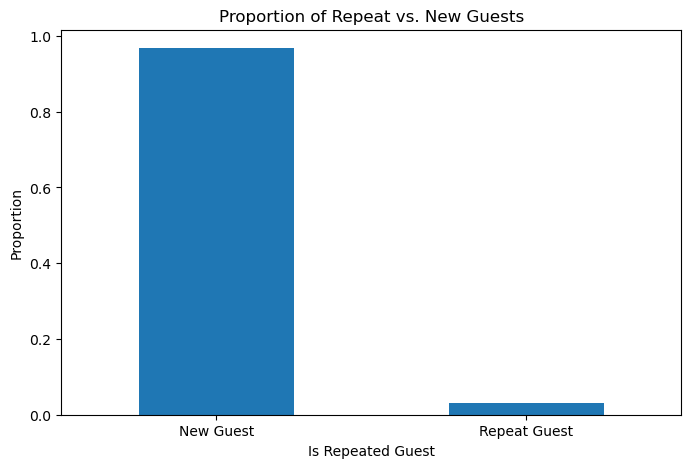

Booking Patterns by Guest Type:
                   lead_time  stays_in_weekend_nights  stays_in_week_nights
is_repeated_guest                                                          
New Guest           0.023785                 0.943416              2.533994
Repeat Guest       -0.721527                 0.447769              1.478215


In [21]:
# Check if 'is_repeated_guest' column exists
if 'is_repeated_guest' in df.columns:
    # Calculate the proportion of repeat guests
    repeat_guest_counts = df['is_repeated_guest'].value_counts(normalize=True)
    repeat_guest_counts.plot(kind='bar', figsize=(8, 5))
    plt.title("Proportion of Repeat vs. New Guests")
    plt.xlabel("Is Repeated Guest")
    plt.ylabel("Proportion")
    plt.xticks([0, 1], labels=["New Guest", "Repeat Guest"], rotation=0)
    plt.show()

    # Analyze booking frequency, stay duration, and lead time by repeat guest status
    repeat_guest_analysis = df.groupby('is_repeated_guest').agg({
        'lead_time': 'mean',
        'stays_in_weekend_nights': 'mean',
        'stays_in_week_nights': 'mean'
    }).rename(index={0: "New Guest", 1: "Repeat Guest"})

    # Display the results
    print("Booking Patterns by Guest Type:")
    print(repeat_guest_analysis)
else:
    print("The dataset does not contain the 'is_repeated_guest' column.")


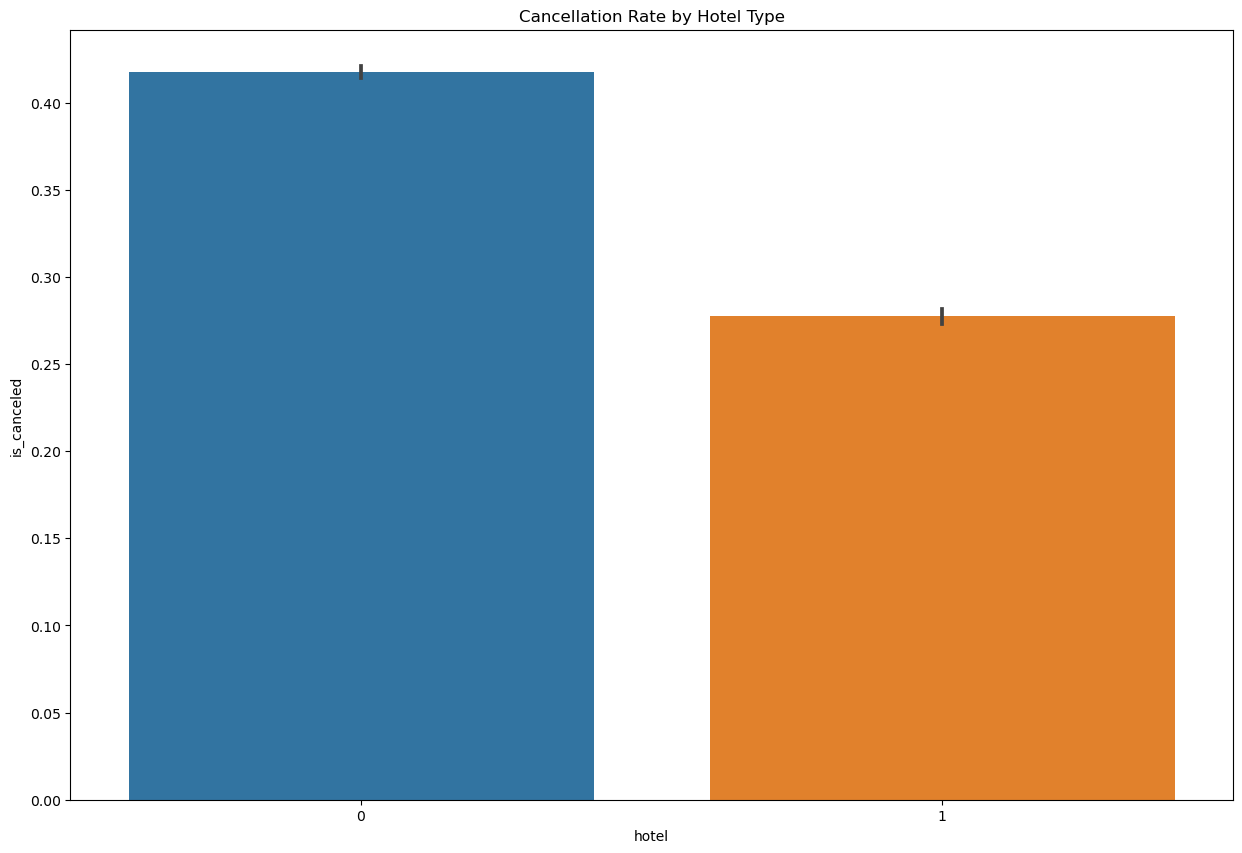

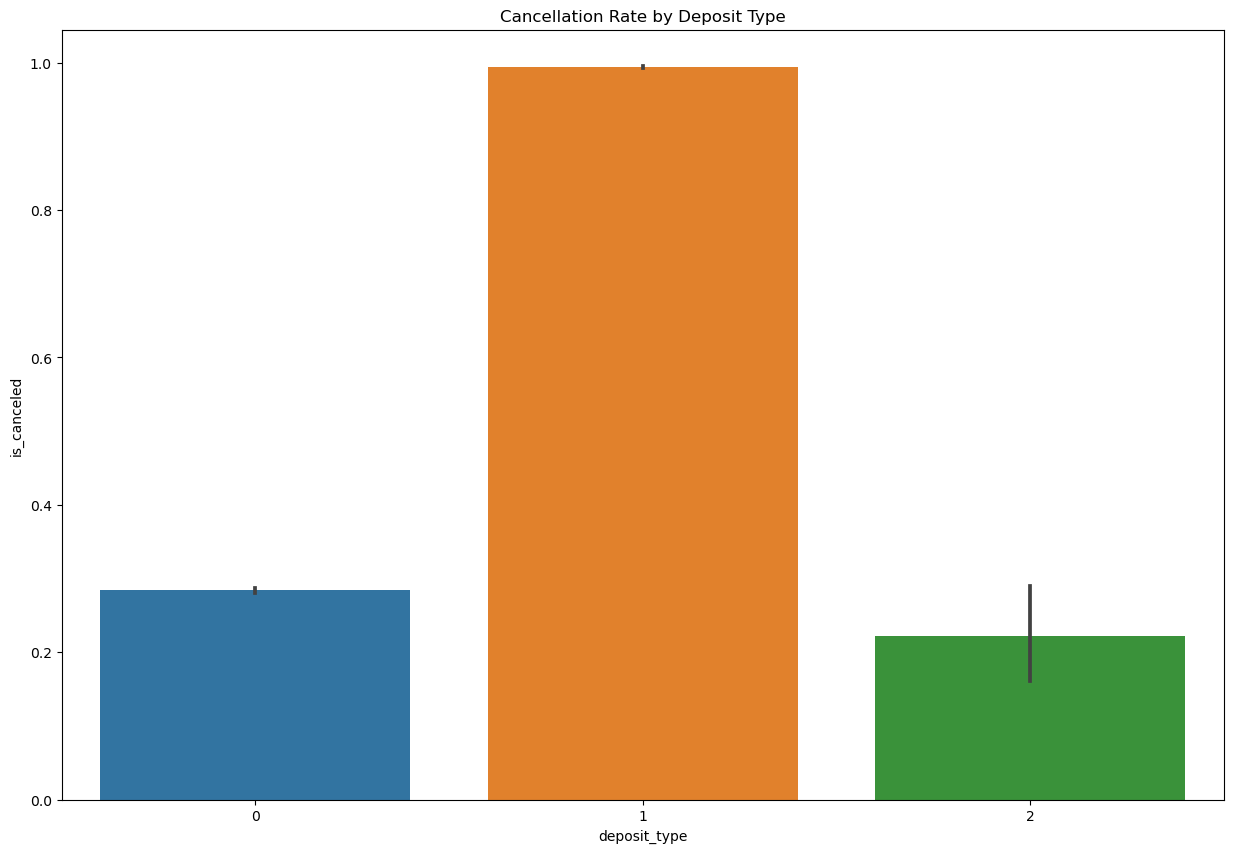

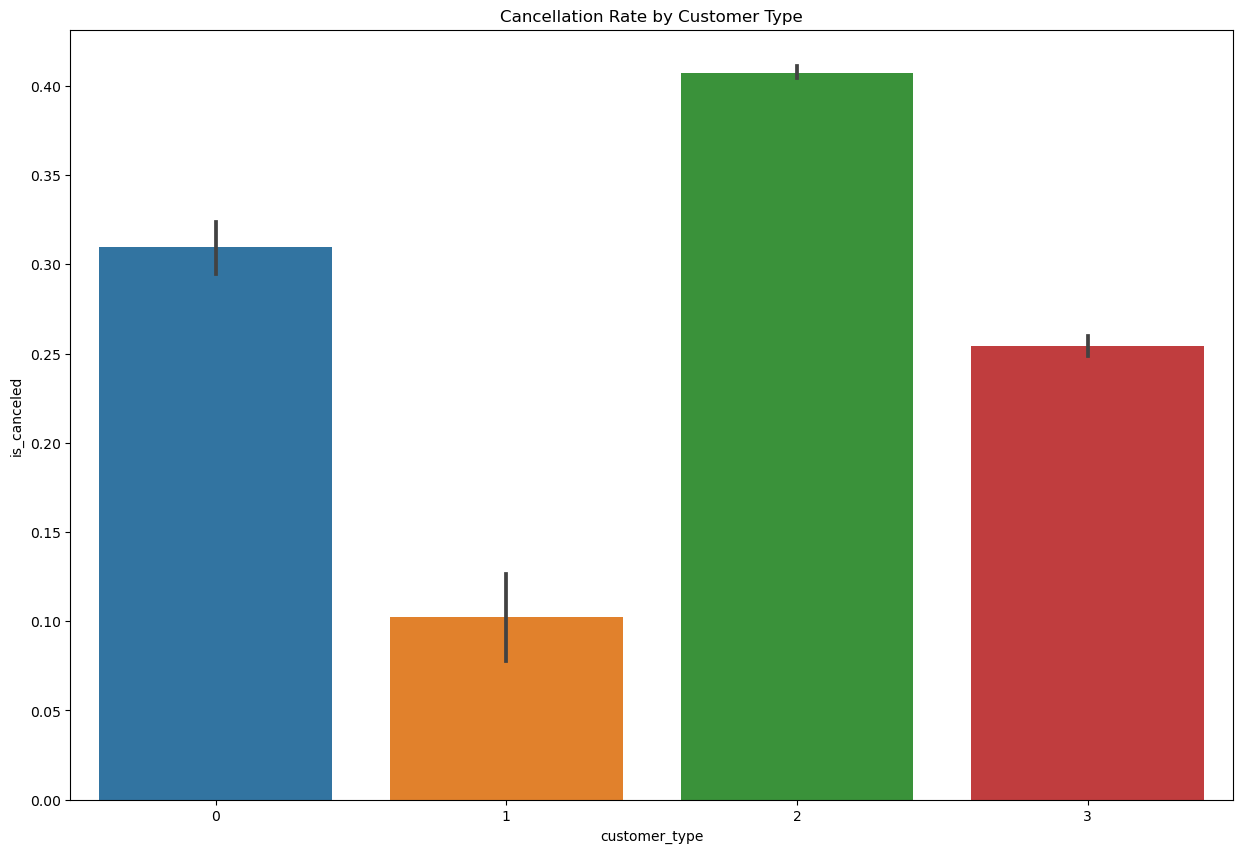

In [22]:
# Cancellation Rates based on Key Features
plt.figure(figsize=(15, 10))
sns.barplot(x='hotel', y='is_canceled', data=df)
plt.title('Cancellation Rate by Hotel Type')
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(x='deposit_type', y='is_canceled', data=df)
plt.title('Cancellation Rate by Deposit Type')
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(x='customer_type', y='is_canceled', data=df)
plt.title('Cancellation Rate by Customer Type')
plt.show()

In [23]:
def detect_and_remove_outliers_iqr(df, columns):
    """
    Detects and removes outliers based on the IQR method for specified columns.
    
    Parameters:
    df (DataFrame): The original DataFrame.
    columns (list): List of columns to check for outliers.
    
    Returns:
    DataFrame, list: The cleaned DataFrame and a list of outlier indices.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    cleaned_df = df.copy()
    outlier_indices = []

    for column in columns:
        # Calculate Q1, Q3, and IQR for each column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find the indices of the outliers in the column
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outlier_indices.extend(column_outliers)

        # Remove outliers from the cleaned DataFrame
        cleaned_df = cleaned_df[~cleaned_df.index.isin(column_outliers)]

    # Remove duplicate indices from outliers list
    outlier_indices = list(set(outlier_indices))
    return cleaned_df, outlier_indices

# Columns to check for outliers
columns_to_check = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 
    'adults', 'children', 'babies', 'previous_cancellations', 
    'previous_bookings_not_canceled', 'days_in_waiting_list', 'adr'
]

# Apply the outlier detection and removal
df_cleaned, outlier_indices = detect_and_remove_outliers_iqr(df, columns_to_check)

# Output result
print(f"Number of outliers removed: {len(outlier_indices)}")
print(f"Shape of cleaned dataset: {df_cleaned.shape}")


Number of outliers removed: 49492
Shape of cleaned dataset: (69898, 34)


In [24]:
# Define features and target variable
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [25]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the shapes of the processed datasets
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")

Training features shape: (95512, 33)
Test features shape: (23878, 33)


In [26]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
# Logistic Regression with L1 Regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', random_state=42, max_iter=500)
logreg_l1.fit(X_train_scaled, y_train)

/Users/harikapunati/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=500, penalty='l1', random_state=42, solver='saga')

In [28]:
# Logistic Regression with L2 Regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='saga', random_state=42, max_iter=500)
logreg_l2.fit(X_train_scaled, y_train)


/Users/harikapunati/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=500, random_state=42, solver='saga')

In [29]:
# Predictions
y_pred_l1 = logreg_l1.predict(X_test_scaled)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

In [30]:
# Evaluation
print("\nLogistic Regression with L1 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l1):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_l1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_l1):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_l1):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_l1))


Logistic Regression with L1 Regularization:
Accuracy: 0.9901
Precision: 0.9998
Recall: 0.9739
F1-score: 0.9867

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



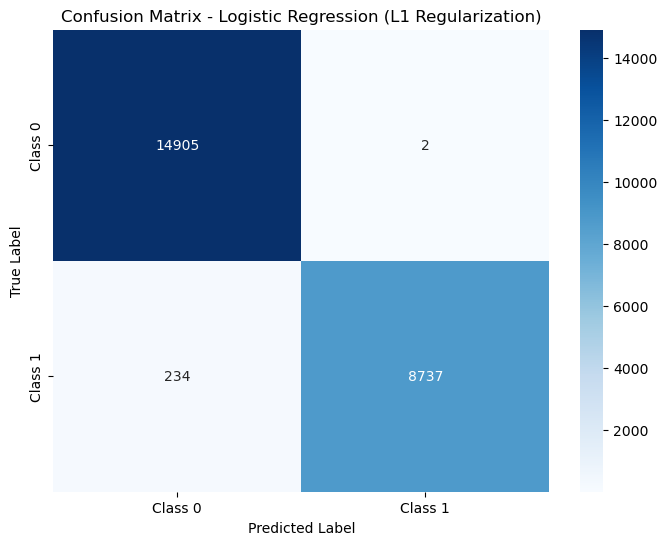

In [31]:
# Compute confusion matrix
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_l1, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression (L1 Regularization)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

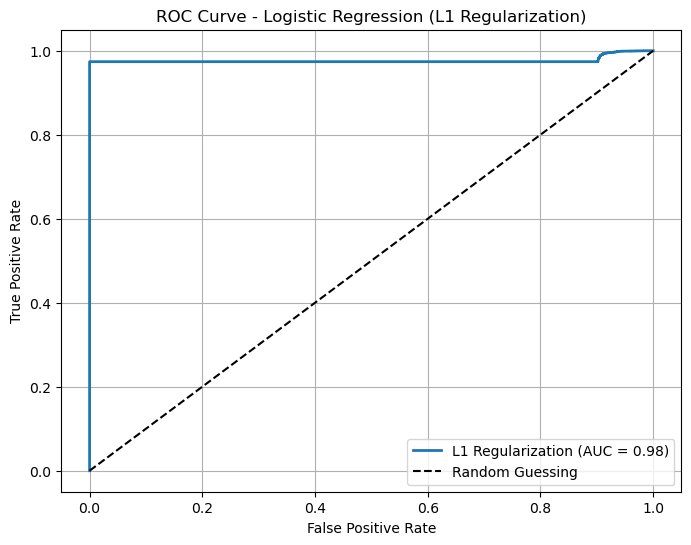

AUC for L1 Regularization: 0.9762


In [32]:
# Predict probabilities for the positive class
y_proba_l1 = logreg_l1.predict_proba(X_test_scaled)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_proba_l1)

# Compute AUC score
auc_l1 = roc_auc_score(y_test, y_proba_l1)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l1, tpr_l1, label=f'L1 Regularization (AUC = {auc_l1:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L1 Regularization)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for L1 Regularization: {auc_l1:.4f}")


In [33]:
print("\nLogistic Regression with L2 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_l2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_l2):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_l2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_l2))



Logistic Regression with L2 Regularization:
Accuracy: 0.9901
Precision: 0.9998
Recall: 0.9739
F1-score: 0.9867

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



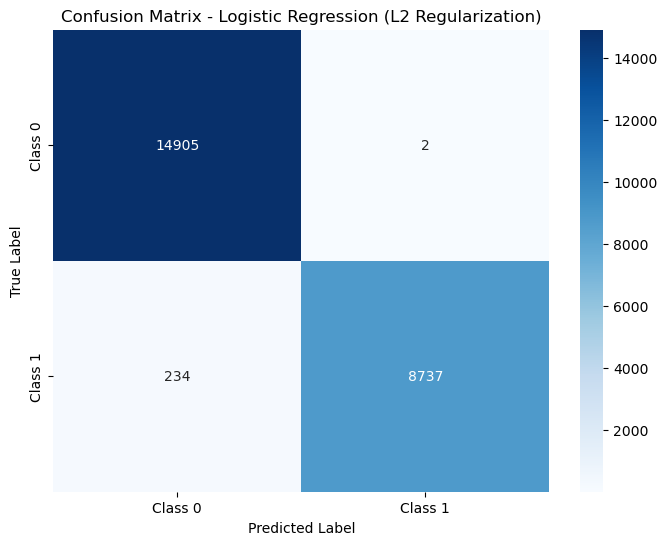

In [34]:
# Compute confusion matrix for L2 regularization
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_l2, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression (L2 Regularization)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Logistic Regression with L2 Regularization:
Accuracy: 0.9901
Precision: 0.9998
Recall: 0.9739
F1-score: 0.9867

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



/Users/harikapunati/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


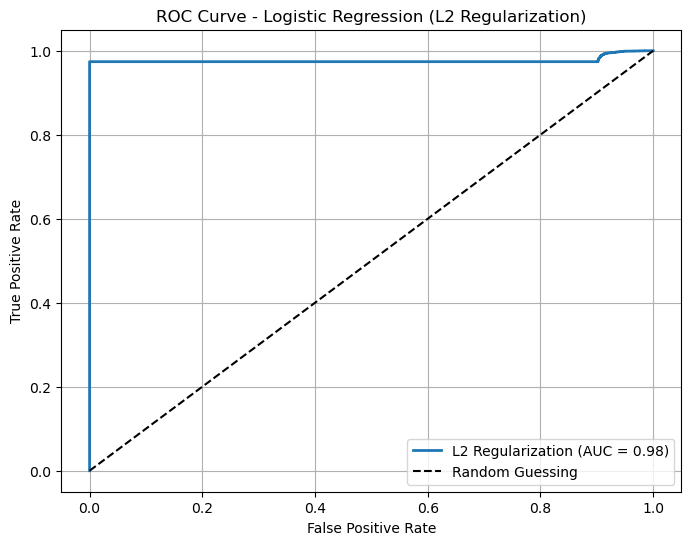

AUC for L2 Regularization: 0.9762


In [35]:
# Logistic Regression with L2 Regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='saga', random_state=42, max_iter=500)
logreg_l2.fit(X_train_scaled, y_train)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

# Evaluation
print("\nLogistic Regression with L2 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_l2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_l2):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_l2):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_l2))


# Predict probabilities for the positive class
y_proba_l2 = logreg_l2.predict_proba(X_test_scaled)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)

# Compute AUC score
auc_l2 = roc_auc_score(y_test, y_proba_l2)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l2, tpr_l2, label=f'L2 Regularization (AUC = {auc_l2:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L2 Regularization)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for L2 Regularization: {auc_l2:.4f}")


In [36]:
# Calculate accuracy for L1 regularization
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
print(f'L1 Regularization Accuracy: {accuracy_l1}')

L1 Regularization Accuracy: 0.9901164251612363


In [37]:
# Calculate accuracy for L2 regularization
accuracy_l2 = accuracy_score(y_test, y_pred_l2)
print(f'L2 Regularization Accuracy: {accuracy_l2}')

L2 Regularization Accuracy: 0.9901164251612363


In [38]:
# Define the parameter grid for L1 regularization
param_grid_l1 = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize Logistic Regression with L1 penalty
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Perform Grid Search with Cross-Validation
grid_search_l1 = GridSearchCV(log_reg_l1, param_grid_l1, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search_l1.fit(X_train, y_train)
# Print the best parameters and the corresponding score
print(f"Best parameters for L1 regularization: {grid_search_l1.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_l1.best_score_:.4f}")

Best parameters for L1 regularization: {'C': 0.01}
Best cross-validation accuracy: 0.9898


In [39]:
# Define the parameter grid for L2 regularization
param_grid_l2 = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize Logistic Regression with L2 penalty
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Perform Grid Search with Cross-Validation
grid_search_l2 = GridSearchCV(log_reg_l2, param_grid_l2, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search_l2.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters for L2 regularization: {grid_search_l2.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_l2.best_score_:.4f}")

Best parameters for L2 regularization: {'C': 0.1}
Best cross-validation accuracy: 0.9897


In [40]:
# Define hyperparameter grid for regularization strength
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize the logistic regression model with L2 regularization
log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Train the model on the training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameter and corresponding accuracy
print("Best Hyperparameter (C):", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameter (C): {'C': 0.1}
Best Cross-Validation Accuracy: 0.9897185771704964


In [41]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

In [42]:
# Best model after tuning
best_log_reg = grid_search.best_estimator_

In [43]:
# Predict on test set
y_pred = best_log_reg.predict(X_test)

In [44]:
# Evaluate using accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [45]:
# Print evaluation metrics
print("Logistic Regression Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Evaluation Metrics:
Accuracy: 0.9899907864980316
Precision: 0.999428048501487
Recall: 0.9739159513989522
F1-score: 0.9865070851916671

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



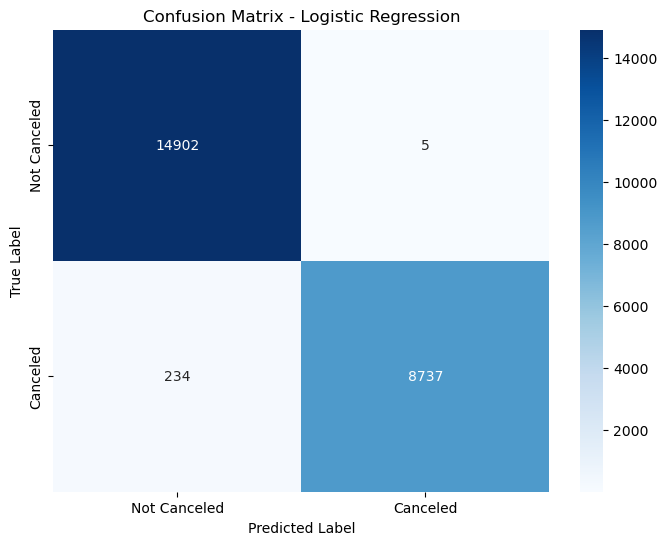

In [46]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [47]:
# Define parameter grid for Logistic Regression with L1 regularization
param_grid_l1 = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Perform grid search with cross-validation
grid_search_l1 = GridSearchCV(log_reg_l1, param_grid_l1, cv=5, scoring='accuracy')
grid_search_l1.fit(X_train, y_train)

# Best Logistic Regression model with L1 regularization after tuning
best_log_reg_l1 = grid_search_l1.best_estimator_

# Predict on test set
y_pred_l1 = best_log_reg_l1.predict(X_test)

# Evaluate using accuracy, precision, recall, and F1-score
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
precision_l1 = precision_score(y_test, y_pred_l1)
recall_l1 = recall_score(y_test, y_pred_l1)
f1_l1 = f1_score(y_test, y_pred_l1)

# Print evaluation metrics for L1-regularized model
print("Logistic Regression (L1) Evaluation Metrics:")
print("Best C for L1:", grid_search_l1.best_params_)
print("Accuracy:", accuracy_l1)
print("Precision:", precision_l1)
print("Recall:", recall_l1)
print("F1-score:", f1_l1)
print("\nClassification Report for L1:\n", classification_report(y_test, y_pred_l1))

Logistic Regression (L1) Evaluation Metrics:
Best C for L1: {'C': 0.01}
Accuracy: 0.9902001842700394
Precision: 1.0
Recall: 0.9739159513989522
F1-score: 0.9867856336119268

Classification Report for L1:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



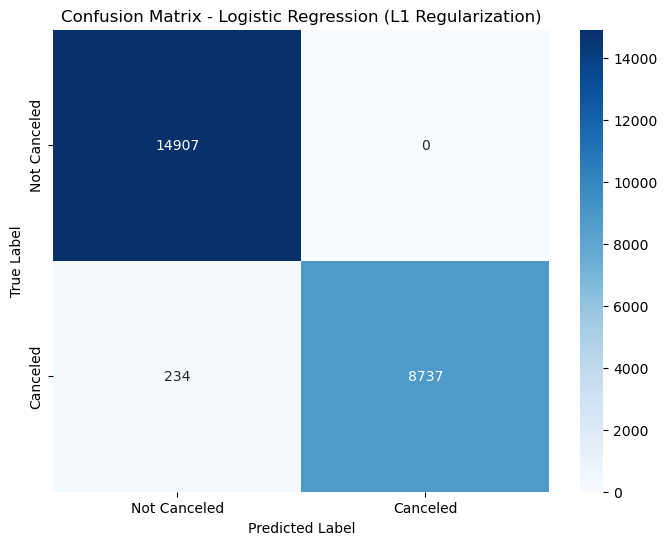

In [48]:
# Compute confusion matrix
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_l1, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (L1 Regularization)")
plt.show()


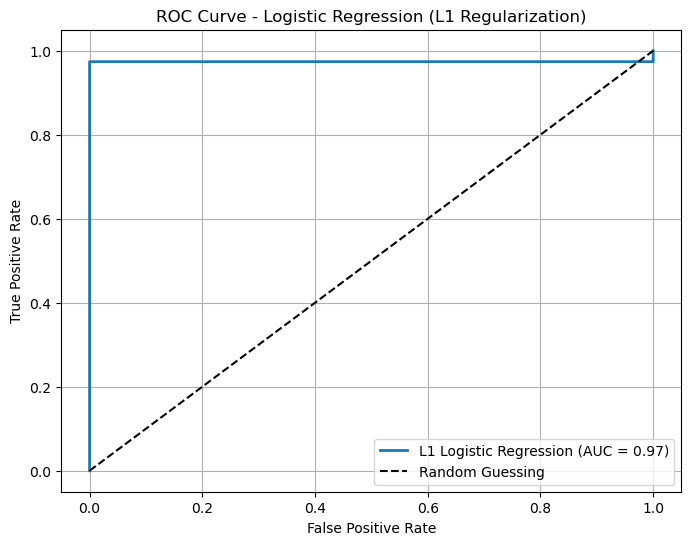

AUC for L1 Logistic Regression: 0.9739


In [49]:
# Get predicted probabilities for the positive class
y_proba_l1 = best_log_reg_l1.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_proba_l1)

# Compute AUC score
auc_l1 = roc_auc_score(y_test, y_proba_l1)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'L1 Logistic Regression (AUC = {auc_l1:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L1 Regularization)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for L1 Logistic Regression: {auc_l1:.4f}")


In [50]:
# Define parameter grid for Logistic Regression with L2 regularization
param_grid_l2 = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Perform grid search with cross-validation
grid_search_l2 = GridSearchCV(log_reg_l2, param_grid_l2, cv=5, scoring='accuracy')
grid_search_l2.fit(X_train, y_train)

# Best Logistic Regression model with L2 regularization after tuning
best_log_reg_l2 = grid_search_l2.best_estimator_

# Predict on test set
y_pred_l2 = best_log_reg_l2.predict(X_test)

# Evaluate using accuracy, precision, recall, and F1-score
accuracy_l2 = accuracy_score(y_test, y_pred_l2)
precision_l2 = precision_score(y_test, y_pred_l2)
recall_l2 = recall_score(y_test, y_pred_l2)
f1_l2 = f1_score(y_test, y_pred_l2)

# Print evaluation metrics for L2-regularized model
print("Logistic Regression (L2) Evaluation Metrics:")
print("Best C for L2:", grid_search_l2.best_params_)
print("Accuracy:", accuracy_l2)
print("Precision:", precision_l2)
print("Recall:", recall_l2)
print("F1-score:", f1_l2)
print("\nClassification Report for L2:\n", classification_report(y_test, y_pred_l2))


Logistic Regression (L2) Evaluation Metrics:
Best C for L2: {'C': 0.1}
Accuracy: 0.9899907864980316
Precision: 0.999428048501487
Recall: 0.9739159513989522
F1-score: 0.9865070851916671

Classification Report for L2:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



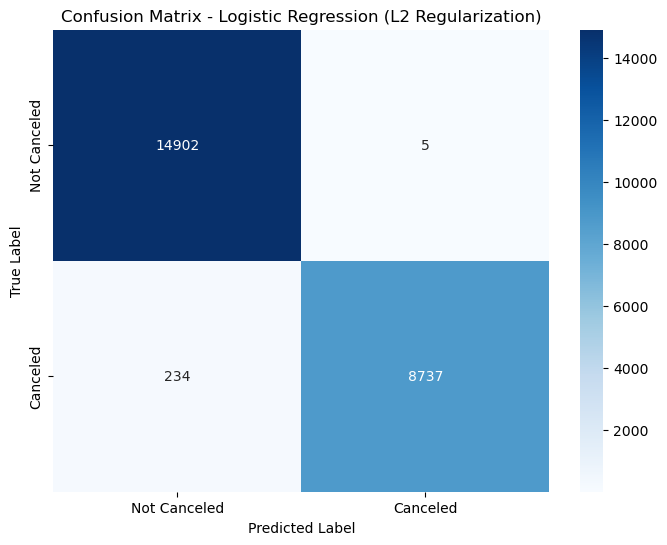

In [51]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (L2 Regularization)")
plt.show()

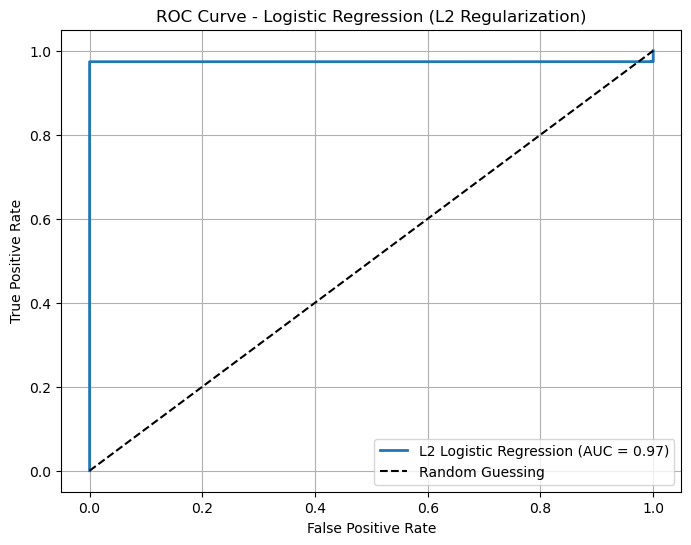

AUC for L2 Logistic Regression: 0.9739


In [52]:
# Get predicted probabilities for the positive class
y_proba_l2 = best_log_reg_l2.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)

# Compute AUC score
auc_l2 = roc_auc_score(y_test, y_proba_l2)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l2, tpr_l2, label=f'L2 Logistic Regression (AUC = {auc_l2:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L2 Regularization)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for L2 Logistic Regression: {auc_l2:.4f}")


In [53]:
# Initialize the XGBoost model
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions with the trained model
y_pred_xgb = xgb_model.predict(X_test)


In [54]:
# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print evaluation metrics for XGBoost
print("XGBoost Evaluation Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-score:", f1_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Evaluation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



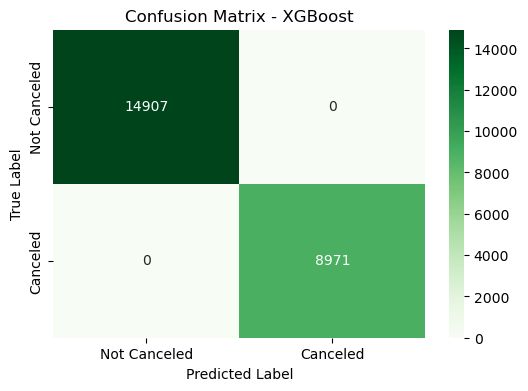

In [55]:
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

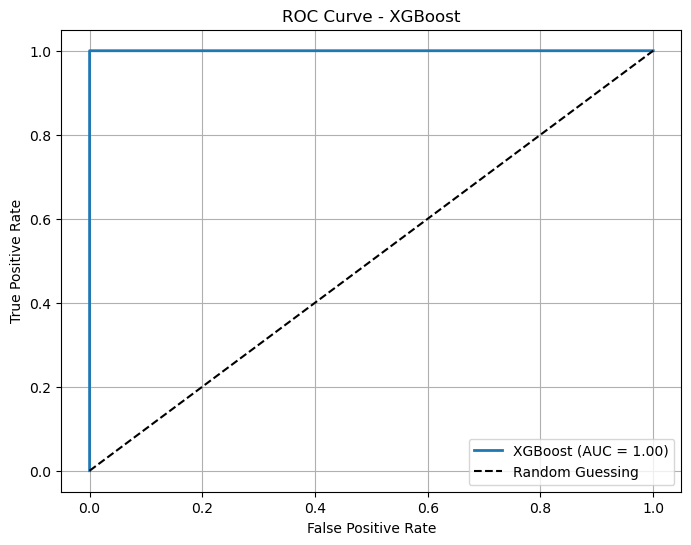

AUC for XGBoost: 1.0000


In [56]:
# Predict probabilities for the positive class
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_xgb:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for XGBoost: {auc_xgb:.4f}")


In [57]:
# Initialize LightGBM model with suppressed verbosity
lgbm_clf = LGBMClassifier(random_state=42, verbosity=-1)  # Set verbosity to -1 to suppress warnings

# Train the model on the training data
lgbm_clf.fit(X_train, y_train)

# Predict on test set
y_pred_lgbm = lgbm_clf.predict(X_test)

In [58]:
# Evaluate LightGBM model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

# Print evaluation metrics for LightGBM
print("LightGBM Evaluation Metrics:")
print("Accuracy:", accuracy_lgbm)
print("Precision:", precision_lgbm)
print("Recall:", recall_lgbm)
print("F1-score:", f1_lgbm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

LightGBM Evaluation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



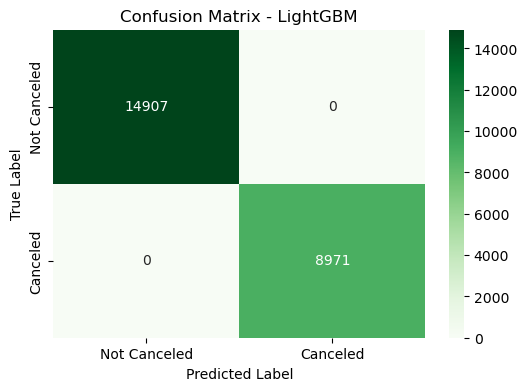

In [59]:
# Confusion Matrix for LightGBM
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Greens", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

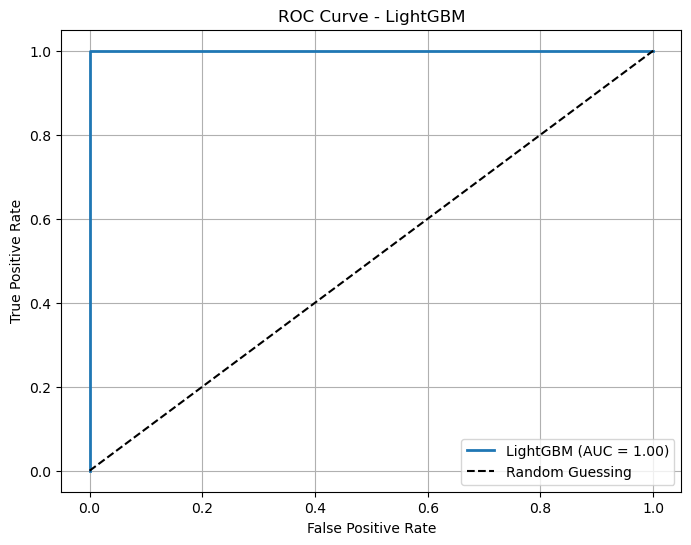

AUC for LightGBM: 1.0000


In [60]:
# Predict probabilities for the positive class
y_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

# Compute AUC score
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for LightGBM: {auc_lgbm:.4f}")

In [61]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Updated XGBoost classifier without 'use_label_encoder'
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best XGBoost model after tuning
best_xgb = grid_search_xgb.best_estimator_

# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print evaluation metrics for XGBoost
print("XGBoost Evaluation Metrics:")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-score:", f1_xgb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost Evaluation Metrics:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



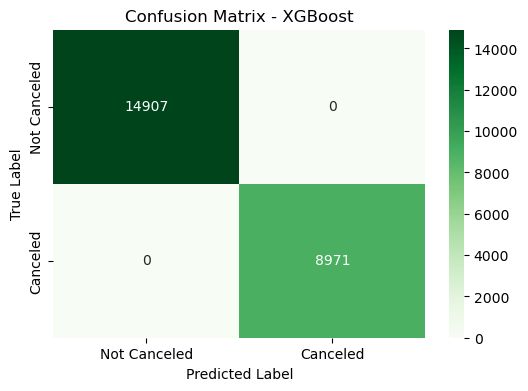

In [62]:
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

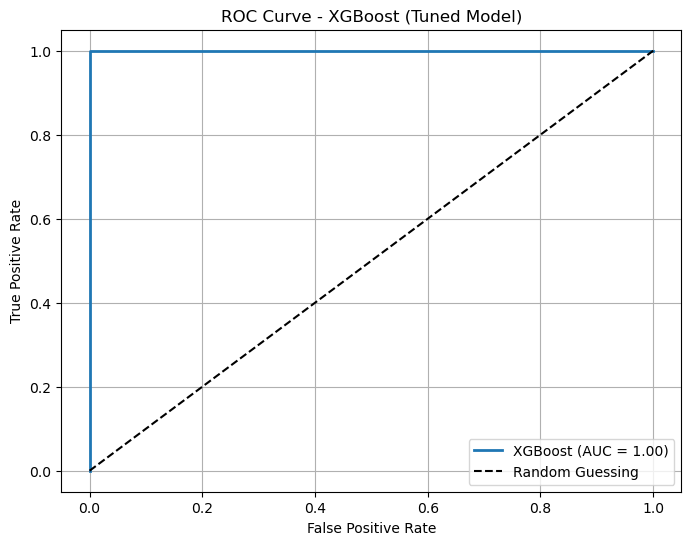

AUC for Tuned XGBoost: 1.0000


In [63]:
# Predict probabilities for the positive class
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Compute AUC score
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - XGBoost (Tuned Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned XGBoost: {auc_xgb:.4f}")


In [64]:
# Define parameter grid for LightGBM, adding min_gain_to_split
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_gain_to_split': [0.01, 0.1]  # Try small values to control split gain threshold
}

# Set verbose to -1 to suppress warnings, and configure the model with min_gain_to_split
lgbm_clf = LGBMClassifier(random_state=42, verbose=-1)  # Suppress internal LightGBM logs
grid_search_lgbm = GridSearchCV(lgbm_clf, param_grid_lgbm, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Best LightGBM model after tuning
best_lgbm = grid_search_lgbm.best_estimator_

# Predict on test set
y_pred_lgbm = best_lgbm.predict(X_test)

# Evaluate LightGBM model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

# Print evaluation metrics for LightGBM
print("LightGBM Evaluation Metrics:")
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Accuracy:", accuracy_lgbm)
print("Precision:", precision_lgbm)
print("Recall:", recall_lgbm)
print("F1-score:", f1_lgbm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

LightGBM Evaluation Metrics:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_gain_to_split': 0.01, 'n_estimators': 50}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



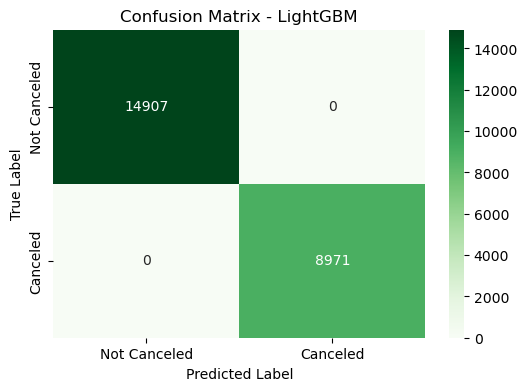

In [65]:
# Confusion Matrix for LightGBM
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Greens", xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

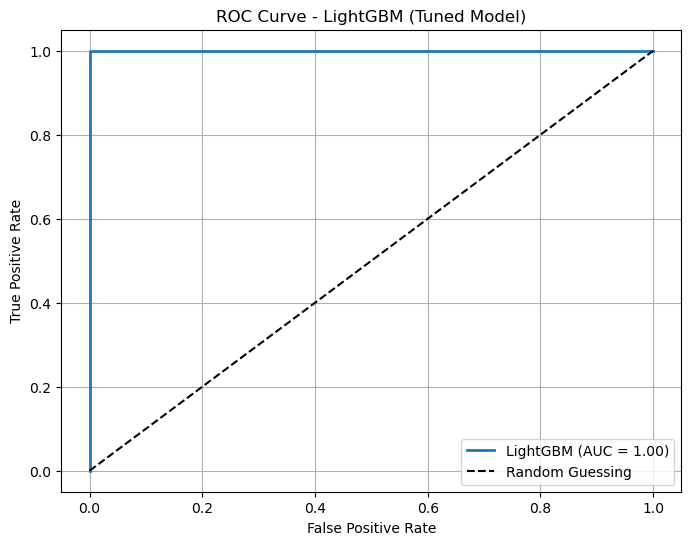

AUC for Tuned LightGBM: 1.0000


In [66]:
# Predict probabilities for the positive class
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

# Compute AUC score
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - LightGBM (Tuned Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned LightGBM: {auc_lgbm:.4f}")


In [67]:
# Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# Apply PCA for Dimensionality Reduction
# Retain enough components to explain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original number of features:", X.shape[1])
print("Reduced number of features after PCA:", X_train_pca.shape[1])


Original number of features: 33
Reduced number of features after PCA: 2


In [69]:
# Logistic Regression with L1 and L2 Regularization on PCA-transformed data
# Define hyperparameters
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}

In [70]:
# Logistic Regression with L1 Regularization
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
grid_search_l1 = GridSearchCV(log_reg_l1, param_grid_lr, cv=5, scoring='accuracy')
grid_search_l1.fit(X_train_pca, y_train)
best_l1 = grid_search_l1.best_estimator_
y_pred_l1 = best_l1.predict(X_test_pca)
print("\nLogistic Regression (L1) on PCA Data")
print("Best C:", grid_search_l1.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_l1))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))



Logistic Regression (L1) on PCA Data
Best C: {'C': 0.01}
Accuracy: 0.6348521651729626
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72     14907
           1       0.52      0.42      0.47      8971

    accuracy                           0.63     23878
   macro avg       0.60      0.59      0.59     23878
weighted avg       0.62      0.63      0.63     23878



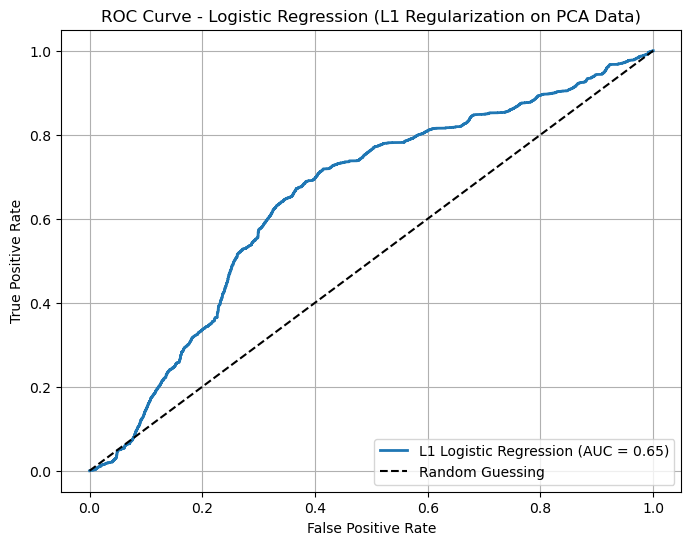

AUC for Tuned Logistic Regression (L1): 0.6494


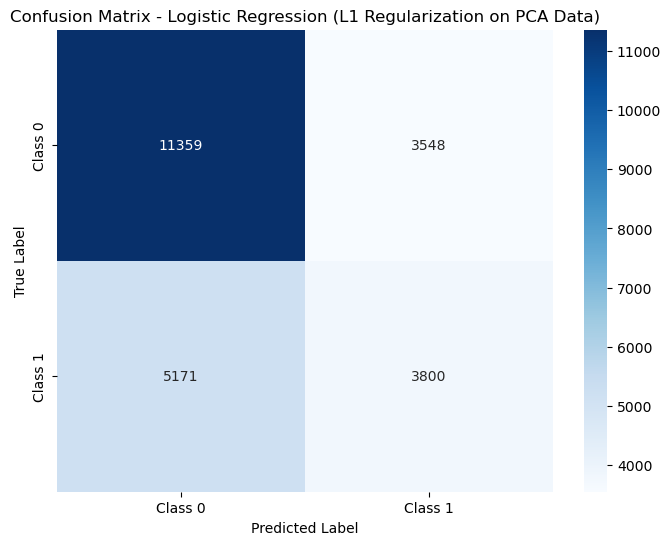

In [71]:
# Predict probabilities for the positive class
y_proba_l1 = best_l1.predict_proba(X_test_pca)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_proba_l1)

# Compute AUC score
auc_l1 = roc_auc_score(y_test, y_proba_l1)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l1, tpr_l1, label=f'L1 Logistic Regression (AUC = {auc_l1:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L1 Regularization on PCA Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned Logistic Regression (L1): {auc_l1:.4f}")

# Compute confusion matrix
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_l1, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression (L1 Regularization on PCA Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [72]:
# Logistic Regression with L2 Regularization
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
grid_search_l2 = GridSearchCV(log_reg_l2, param_grid_lr, cv=5, scoring='accuracy')
grid_search_l2.fit(X_train_pca, y_train)
best_l2 = grid_search_l2.best_estimator_
y_pred_l2 = best_l2.predict(X_test_pca)
print("\nLogistic Regression (L2) on PCA Data")
print("Best C:", grid_search_l2.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_l2))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))



Logistic Regression (L2) on PCA Data
Best C: {'C': 0.01}
Accuracy: 0.6345590082921517
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72     14907
           1       0.52      0.42      0.46      8971

    accuracy                           0.63     23878
   macro avg       0.60      0.59      0.59     23878
weighted avg       0.62      0.63      0.63     23878



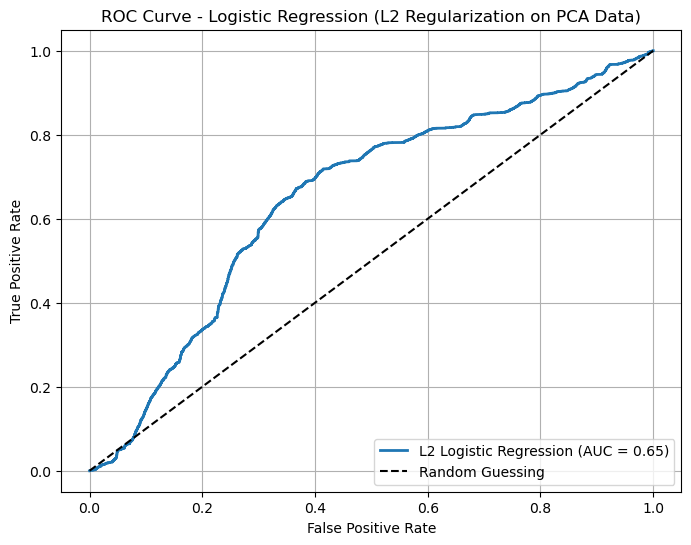

AUC for Tuned Logistic Regression (L2): 0.6494


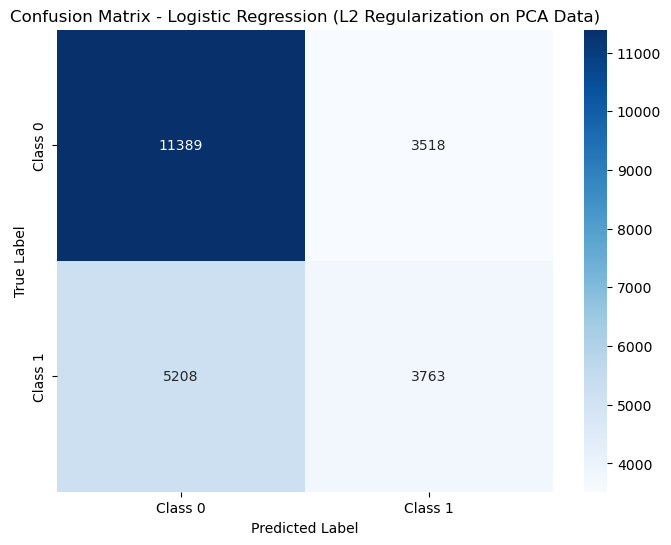

In [73]:
# Predict probabilities for the positive class
y_proba_l2 = best_l2.predict_proba(X_test_pca)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)

# Compute AUC score
auc_l2 = roc_auc_score(y_test, y_proba_l2)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l2, tpr_l2, label=f'L2 Logistic Regression (AUC = {auc_l2:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - Logistic Regression (L2 Regularization on PCA Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned Logistic Regression (L2): {auc_l2:.4f}")

# Compute confusion matrix
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_l2, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression (L2 Regularization on PCA Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [74]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")

In [75]:
# Gradient Boosting with XGBoost on PCA-transformed data
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5]
}

# Instantiate XGBClassifier without 'use_label_encoder' parameter
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=5, scoring='accuracy')

# Fit the model on the PCA-transformed training data
grid_search_xgb.fit(X_train_pca, y_train)

# Best estimator after tuning
best_xgb = grid_search_xgb.best_estimator_

# Predict on PCA-transformed test data
y_pred_xgb = best_xgb.predict(X_test_pca)

# Output results
print("\nXGBoost on PCA Data")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))



XGBoost on PCA Data
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.7630873607504817
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     14907
           1       0.74      0.58      0.65      8971

    accuracy                           0.76     23878
   macro avg       0.76      0.73      0.73     23878
weighted avg       0.76      0.76      0.76     23878



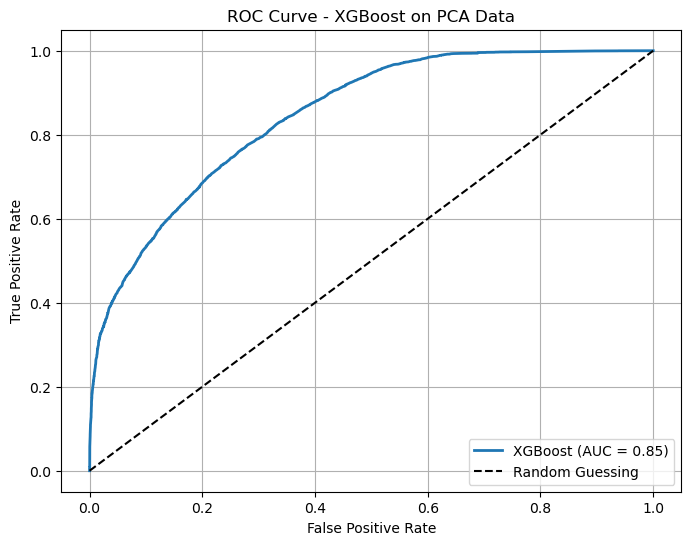

AUC for Tuned XGBoost: 0.8463


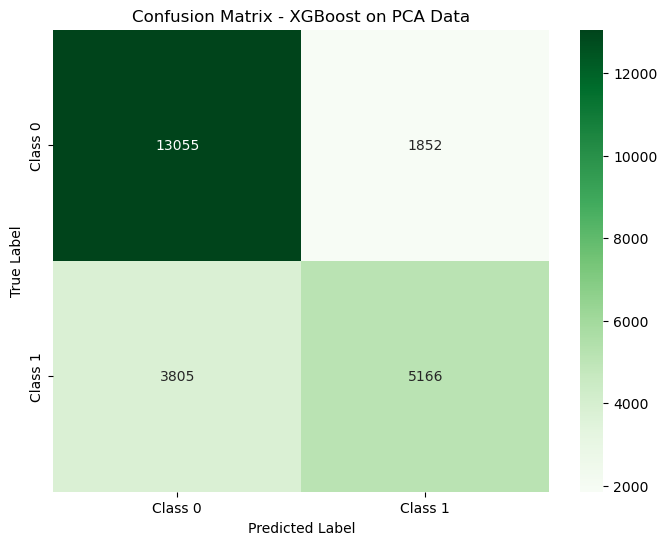

In [76]:
# Predict probabilities for the positive class
y_proba_xgb = best_xgb.predict_proba(X_test_pca)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Compute AUC score
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - XGBoost on PCA Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned XGBoost: {auc_xgb:.4f}")

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - XGBoost on PCA Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [77]:
# Define parameter grid for LightGBM with min_gain_to_split to control splits
param_grid_lgbm = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_gain_to_split': [0.01]  # Adding min_gain_to_split to prevent unnecessary splits
}

# Initialize LightGBM with verbose set to -1 to suppress logs
lgbm_clf = LGBMClassifier(random_state=42, verbose=-1)
grid_search_lgbm = GridSearchCV(lgbm_clf, param_grid_lgbm, cv=5, scoring='accuracy', verbose=0)
grid_search_lgbm.fit(X_train_pca, y_train)

# Best LightGBM model after tuning
best_lgbm = grid_search_lgbm.best_estimator_

# Predict on test set
y_pred_lgbm = best_lgbm.predict(X_test_pca)

# Print results
print("\nLightGBM on PCA Data")
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))



LightGBM on PCA Data
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_gain_to_split': 0.01, 'n_estimators': 100}
Accuracy: 0.76250104698886
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     14907
           1       0.73      0.58      0.65      8971

    accuracy                           0.76     23878
   macro avg       0.75      0.73      0.73     23878
weighted avg       0.76      0.76      0.76     23878



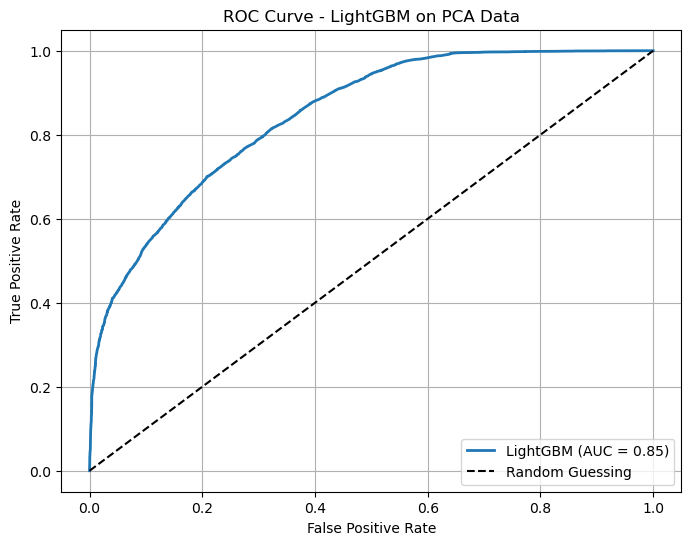

AUC for Tuned LightGBM: 0.8462


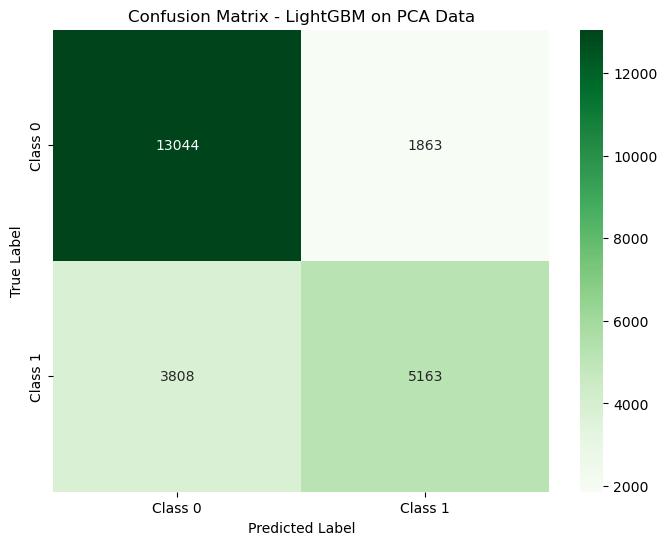

In [78]:
# Predict probabilities for the positive class
y_proba_lgbm = best_lgbm.predict_proba(X_test_pca)[:, 1]

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

# Compute AUC score
auc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve - LightGBM on PCA Data")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC for Tuned LightGBM: {auc_lgbm:.4f}")

# Compute confusion matrix
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - LightGBM on PCA Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [79]:
results = []

In [80]:
# Logistic Regression with L1 Regularization
l1_model = best_l1  # Use the best tuned model from GridSearchCV
y_pred_l1 = l1_model.predict(X_test_pca)
results.append({
    'Model': 'Logistic Regression (L1)',
    'Accuracy': accuracy_score(y_test, y_pred_l1),
    'Precision': precision_score(y_test, y_pred_l1),
    'Recall': recall_score(y_test, y_pred_l1),
    'F1-Score': f1_score(y_test, y_pred_l1)
})



In [81]:
# Logistic Regression with L2 Regularization
l2_model = best_l2  # Use the best tuned model from GridSearchCV
y_pred_l2 = l2_model.predict(X_test_pca)
results.append({
    'Model': 'Logistic Regression (L2)',
    'Accuracy': accuracy_score(y_test, y_pred_l2),
    'Precision': precision_score(y_test, y_pred_l2),
    'Recall': recall_score(y_test, y_pred_l2),
    'F1-Score': f1_score(y_test, y_pred_l2)
})

In [82]:
# XGBoost Model
xgb_model = best_xgb  # Use the best tuned model from RandomizedSearchCV
y_pred_xgb = xgb_model.predict(X_test_pca)
results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb)
})


In [83]:
# LightGBM Model
lgbm_model = best_lgbm  # Use the best tuned model from RandomizedSearchCV
y_pred_lgbm = lgbm_model.predict(X_test_pca)
results.append({
    'Model': 'LightGBM',
    'Accuracy': accuracy_score(y_test, y_pred_lgbm),
    'Precision': precision_score(y_test, y_pred_lgbm),
    'Recall': recall_score(y_test, y_pred_lgbm),
    'F1-Score': f1_score(y_test, y_pred_lgbm)
})


In [84]:
# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)

In [85]:
# Display the results to identify the best-performing model
results_df.sort_values(by='F1-Score', ascending=False, inplace=True)  # Sort by F1-Score
print("Model Comparison Results:")
print(results_df)

Model Comparison Results:
                      Model  Accuracy  Precision    Recall  F1-Score
2                   XGBoost  0.763087   0.736107  0.575856  0.646194
3                  LightGBM  0.762501   0.734842  0.575521  0.645496
0  Logistic Regression (L1)  0.634852   0.517148  0.423587  0.465715
1  Logistic Regression (L2)  0.634559   0.516825  0.419463  0.463081


In [86]:
import time 

In [87]:

# Dictionary to store model metrics and training times
results = []

# Function to evaluate and time models
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()  # Track the start time
    model.fit(X_train, y_train)
    train_time = time.time() - start_time  # Calculate training time
    
    # Predictions and metrics
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training Time (s)': train_time
    })

# Evaluate Logistic Regression (L1 Regularization)
evaluate_model(best_l1, 'Logistic Regression (L1)', X_train_pca, X_test_pca, y_train, y_test)

# Evaluate Logistic Regression (L2 Regularization)
evaluate_model(best_l2, 'Logistic Regression (L2)', X_train_pca, X_test_pca, y_train, y_test)

# Evaluate XGBoost Model
evaluate_model(best_xgb, 'XGBoost', X_train_pca, X_test_pca, y_train, y_test)

# Evaluate LightGBM Model
evaluate_model(best_lgbm, 'LightGBM', X_train_pca, X_test_pca, y_train, y_test)

# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(results)

# Rank models by F1-Score, Precision, and Training Time as a tiebreaker
results_df.sort_values(by=['F1-Score', 'Precision', 'Training Time (s)'], ascending=[False, False, True], inplace=True)

# Display the comparison and best-performing model
print("Model Comparison Results:")
print(results_df)

# Best-performing model based on the criteria
best_model_info = results_df.iloc[0]
print("\nBest-Performing Model:")
print(best_model_info)


Model Comparison Results:
                      Model  Accuracy  Precision    Recall  F1-Score  \
2                   XGBoost  0.763087   0.736107  0.575856  0.646194   
3                  LightGBM  0.762501   0.734842  0.575521  0.645496   
0  Logistic Regression (L1)  0.634852   0.517148  0.423587  0.465715   
1  Logistic Regression (L2)  0.634559   0.516825  0.419463  0.463081   

   Training Time (s)  
2           0.353652  
3           0.133810  
0           0.032556  
1           0.063115  

Best-Performing Model:
Model                 XGBoost
Accuracy             0.763087
Precision            0.736107
Recall               0.575856
F1-Score             0.646194
Training Time (s)    0.353652
Name: 2, dtype: object


                   Accuracy  Precision    Recall  F1-Score       AUC
L1 Regularization  0.634852   0.517148  0.423587  0.465715  0.649374
L2 Regularization  0.634559   0.516825  0.419463  0.463081  0.649374


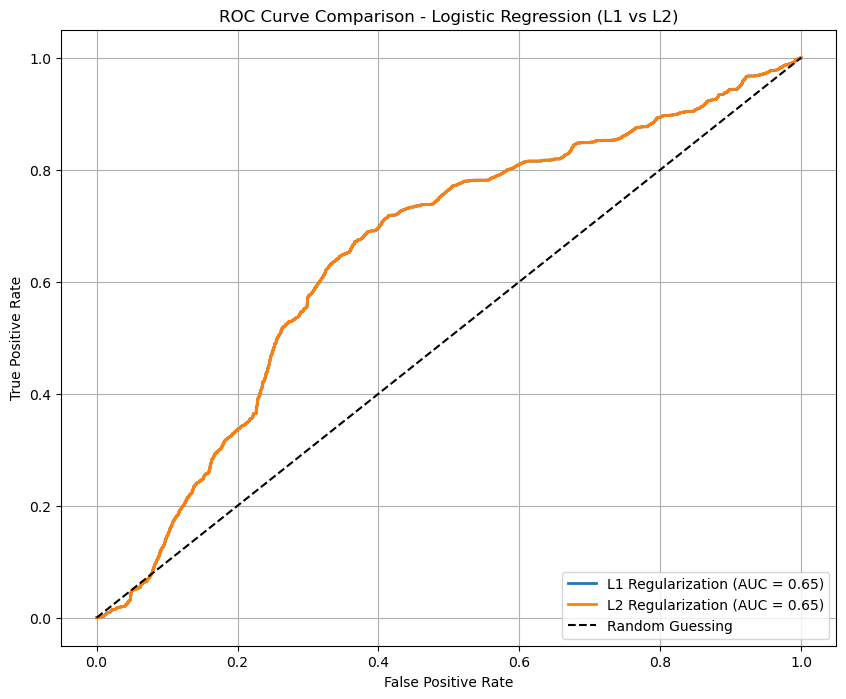

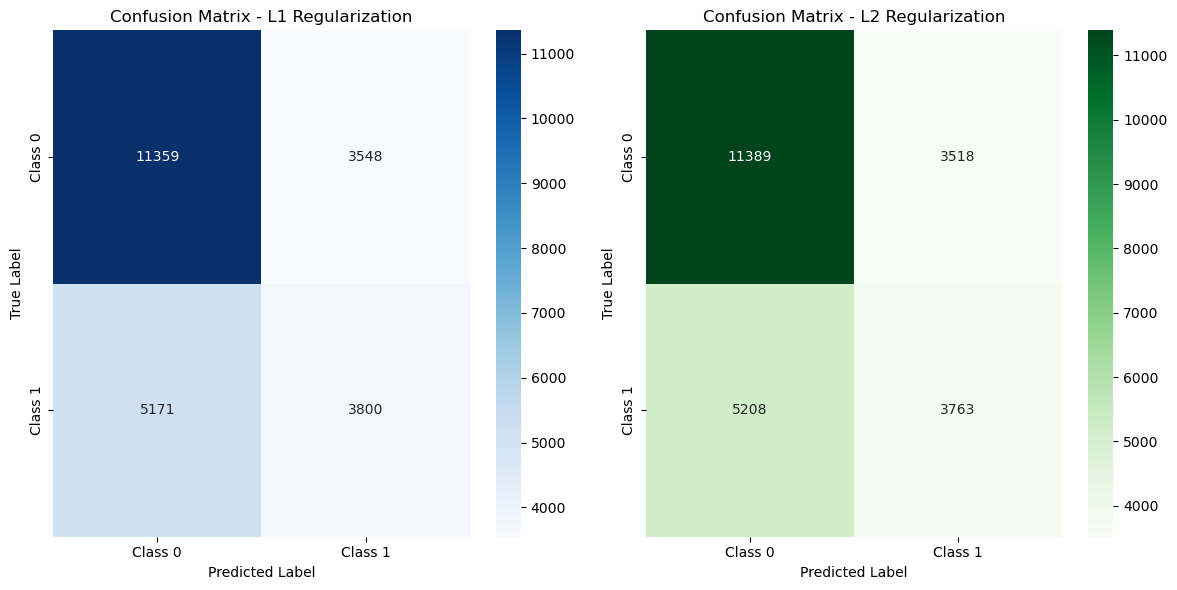

In [88]:
# Metrics for L1
metrics_l1 = {
    "Accuracy": accuracy_score(y_test, y_pred_l1),
    "Precision": precision_score(y_test, y_pred_l1),
    "Recall": recall_score(y_test, y_pred_l1),
    "F1-Score": f1_score(y_test, y_pred_l1),
    "AUC": roc_auc_score(y_test, y_proba_l1)
}

# Metrics for L2
metrics_l2 = {
    "Accuracy": accuracy_score(y_test, y_pred_l2),
    "Precision": precision_score(y_test, y_pred_l2),
    "Recall": recall_score(y_test, y_pred_l2),
    "F1-Score": f1_score(y_test, y_pred_l2),
    "AUC": roc_auc_score(y_test, y_proba_l2)
}

# Combine metrics into a DataFrame
metrics_comparison_lr = pd.DataFrame([metrics_l1, metrics_l2], index=["L1 Regularization", "L2 Regularization"])
print(metrics_comparison_lr)

# ROC Curves
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_proba_l1)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)

plt.figure(figsize=(10, 8))
plt.plot(fpr_l1, tpr_l1, label=f'L1 Regularization (AUC = {metrics_l1["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_l2, tpr_l2, label=f'L2 Regularization (AUC = {metrics_l2["AUC"]:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison - Logistic Regression (L1 vs L2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrices
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_l1, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - L1 Regularization")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_l2, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - L2 Regularization")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


          Accuracy  Precision    Recall  F1-Score       AUC
XGBoost   0.763087   0.736107  0.575856  0.646194  0.846347
LightGBM  0.762501   0.734842  0.575521  0.645496  0.846171


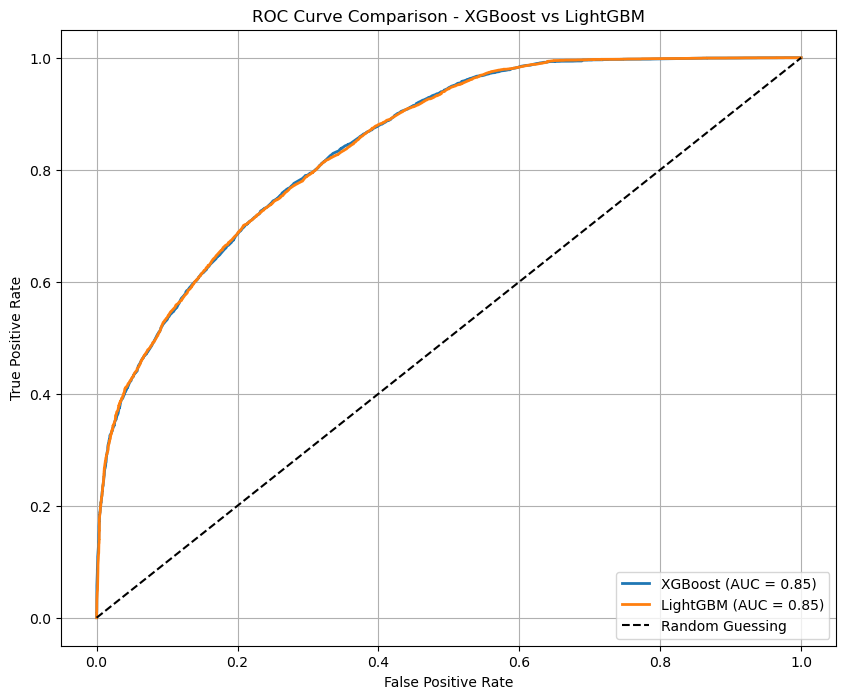

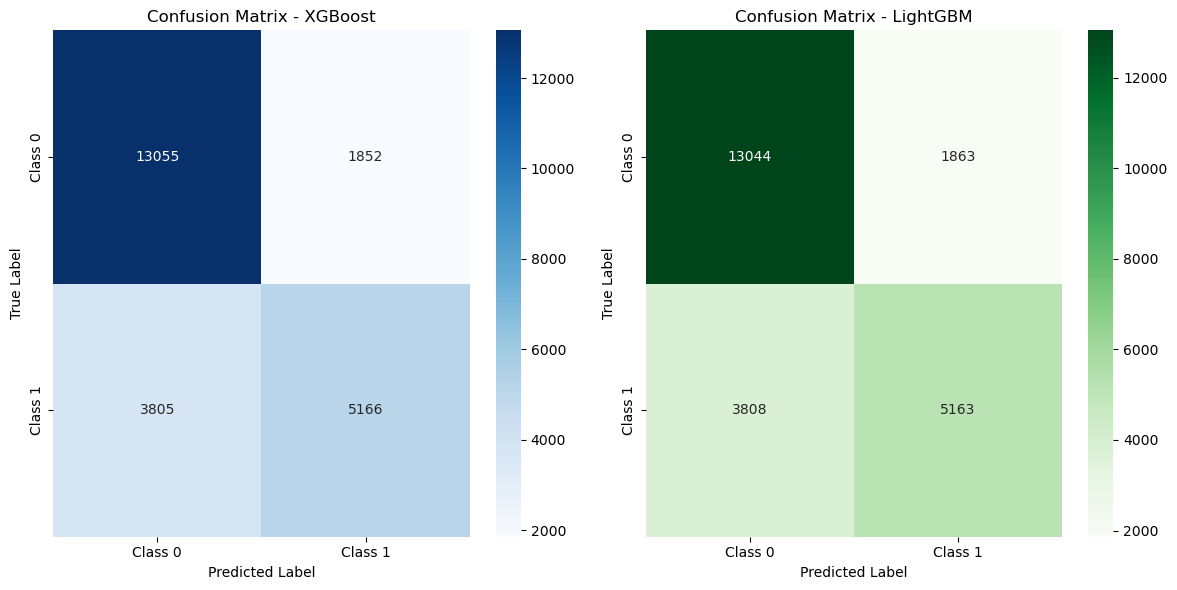

In [89]:
# Metrics for XGBoost
metrics_xgb = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_proba_xgb)
}

# Metrics for LightGBM
metrics_lgbm = {
    "Accuracy": accuracy_score(y_test, y_pred_lgbm),
    "Precision": precision_score(y_test, y_pred_lgbm),
    "Recall": recall_score(y_test, y_pred_lgbm),
    "F1-Score": f1_score(y_test, y_pred_lgbm),
    "AUC": roc_auc_score(y_test, y_proba_lgbm)
}

# Combine metrics into a DataFrame
metrics_comparison_gb = pd.DataFrame([metrics_xgb, metrics_lgbm], index=["XGBoost", "LightGBM"])
print(metrics_comparison_gb)

# ROC Curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {metrics_xgb["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {metrics_lgbm["AUC"]:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison - XGBoost vs LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrices
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


In [90]:
# Compute metrics for all models
metrics = {
    "L1 Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_l1),
        "Precision": precision_score(y_test, y_pred_l1),
        "Recall": recall_score(y_test, y_pred_l1),
        "F1-Score": f1_score(y_test, y_pred_l1),
        "AUC": roc_auc_score(y_test, y_proba_l1),
    },
    "L2 Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_l2),
        "Precision": precision_score(y_test, y_pred_l2),
        "Recall": recall_score(y_test, y_pred_l2),
        "F1-Score": f1_score(y_test, y_pred_l2),
        "AUC": roc_auc_score(y_test, y_proba_l2),
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb),
        "Recall": recall_score(y_test, y_pred_xgb),
        "F1-Score": f1_score(y_test, y_pred_xgb),
        "AUC": roc_auc_score(y_test, y_proba_xgb),
    },
    "LightGBM": {
        "Accuracy": accuracy_score(y_test, y_pred_lgbm),
        "Precision": precision_score(y_test, y_pred_lgbm),
        "Recall": recall_score(y_test, y_pred_lgbm),
        "F1-Score": f1_score(y_test, y_pred_lgbm),
        "AUC": roc_auc_score(y_test, y_proba_lgbm),
    },
}

# Convert metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                        Accuracy  Precision    Recall  F1-Score       AUC
L1 Logistic Regression  0.634852   0.517148  0.423587  0.465715  0.649374
L2 Logistic Regression  0.634559   0.516825  0.419463  0.463081  0.649374
XGBoost                 0.763087   0.736107  0.575856  0.646194  0.846347
LightGBM                0.762501   0.734842  0.575521  0.645496  0.846171


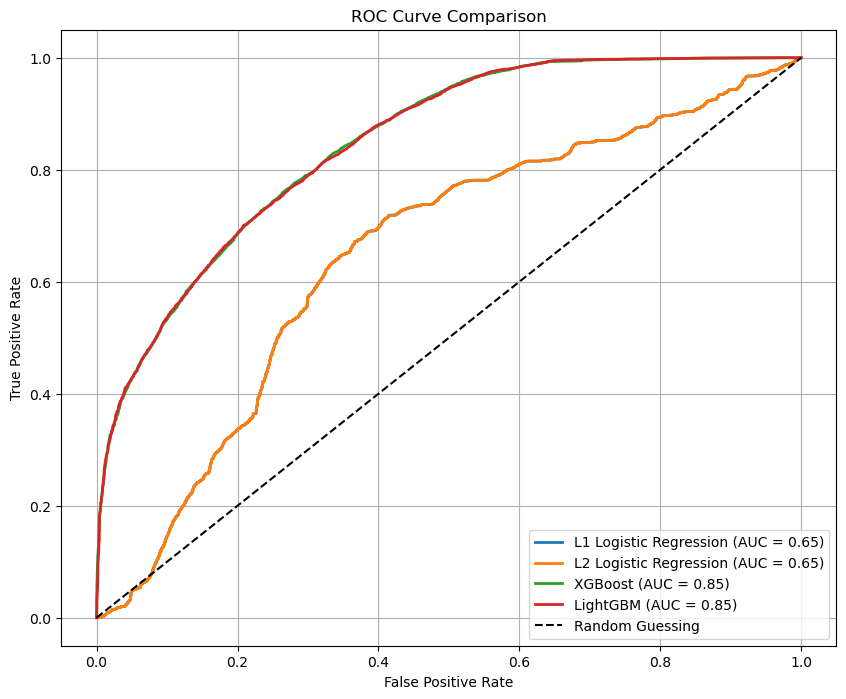

In [91]:
# Compute ROC curves
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_proba_l1)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_proba_l2)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_l1, tpr_l1, label=f'L1 Logistic Regression (AUC = {metrics["L1 Logistic Regression"]["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_l2, tpr_l2, label=f'L2 Logistic Regression (AUC = {metrics["L2 Logistic Regression"]["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {metrics["XGBoost"]["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {metrics["LightGBM"]["AUC"]:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


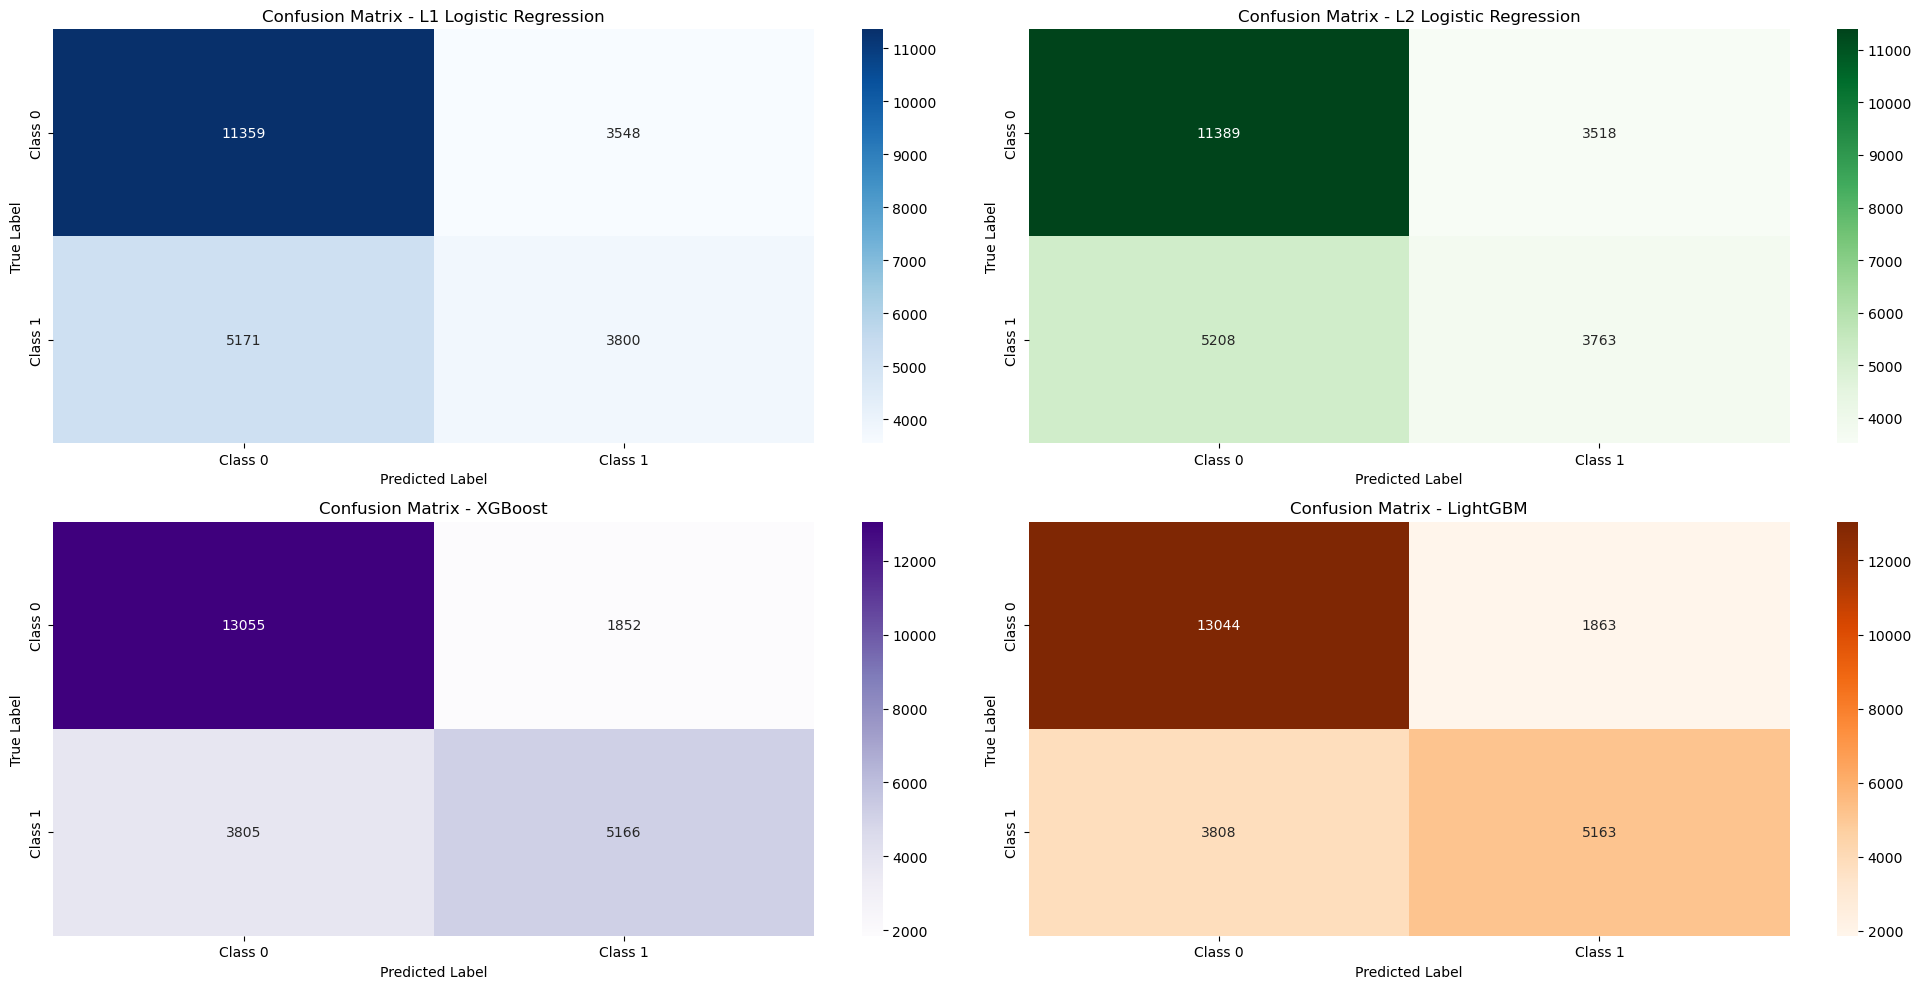

In [92]:
# Confusion Matrices
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Plot all confusion matrices side by side
plt.figure(figsize=(20, 10))

# L1 Logistic Regression
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix_l1, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - L1 Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# L2 Logistic Regression
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_l2, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - L2 Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# XGBoost
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Purples", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# LightGBM
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Oranges", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


Comparison of Logistic Regression and XGBoost:
                     Accuracy  Precision    Recall  F1-Score       AUC
Logistic Regression  0.634852   0.517148  0.423587  0.465715  0.649374
XGBoost              0.763087   0.736107  0.575856  0.646194  0.846347


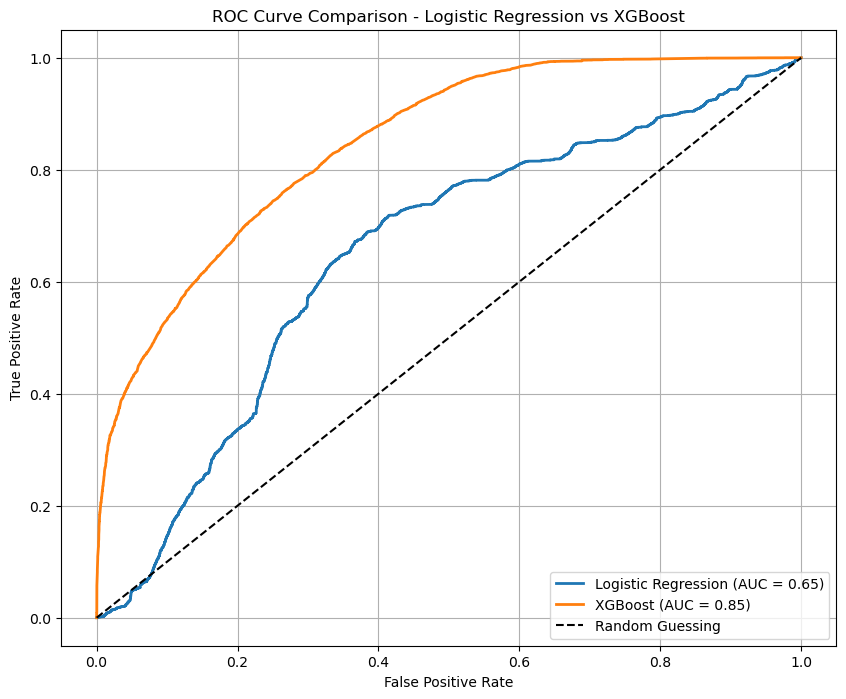

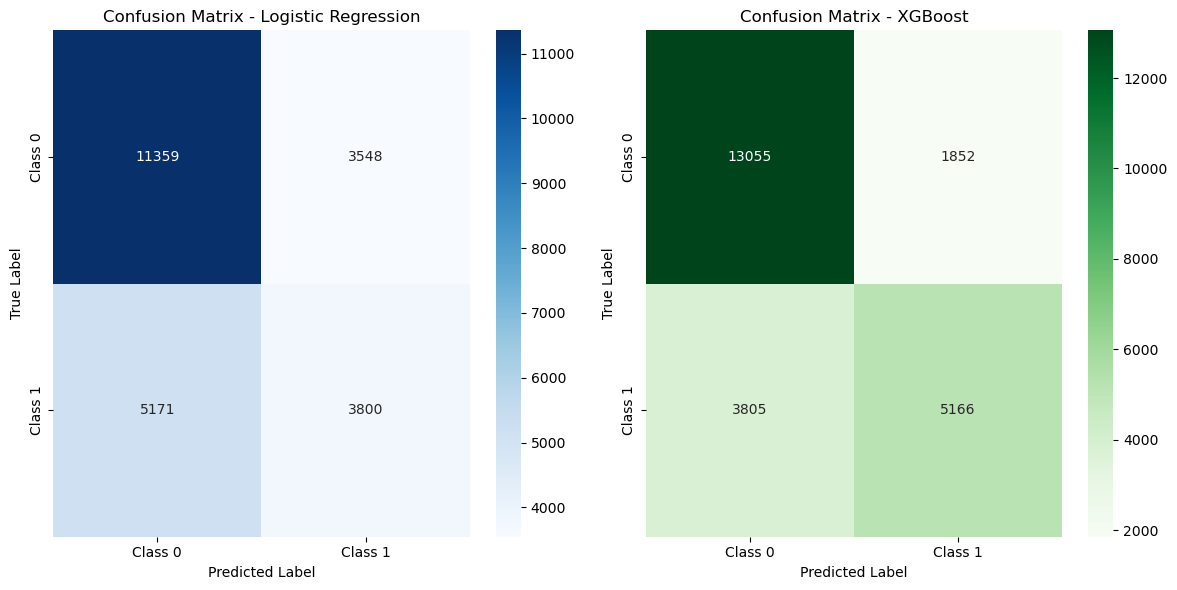

In [93]:
# Metrics for Logistic Regression
metrics_lr = {
    "Accuracy": accuracy_score(y_test, y_pred_l1),
    "Precision": precision_score(y_test, y_pred_l1),
    "Recall": recall_score(y_test, y_pred_l1),
    "F1-Score": f1_score(y_test, y_pred_l1),
    "AUC": roc_auc_score(y_test, y_proba_l1),
}

# Metrics for XGBoost
metrics_xgb = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "AUC": roc_auc_score(y_test, y_proba_xgb),
}

# Combine metrics into a DataFrame
comparison_lr_xgb = pd.DataFrame([metrics_lr, metrics_xgb], index=["Logistic Regression", "XGBoost"])
print("Comparison of Logistic Regression and XGBoost:")
print(comparison_lr_xgb)

# Plot ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_l1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metrics_lr["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {metrics_xgb["AUC"]:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison - Logistic Regression vs XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Confusion Matrices
conf_matrix_lr = confusion_matrix(y_test, y_pred_l1)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(12, 6))

# Logistic Regression
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# XGBoost
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


Comparison of Logistic Regression and LightGBM:
                     Accuracy  Precision    Recall  F1-Score       AUC
Logistic Regression  0.634852   0.517148  0.423587  0.465715  0.649374
LightGBM             0.762501   0.734842  0.575521  0.645496  0.846171


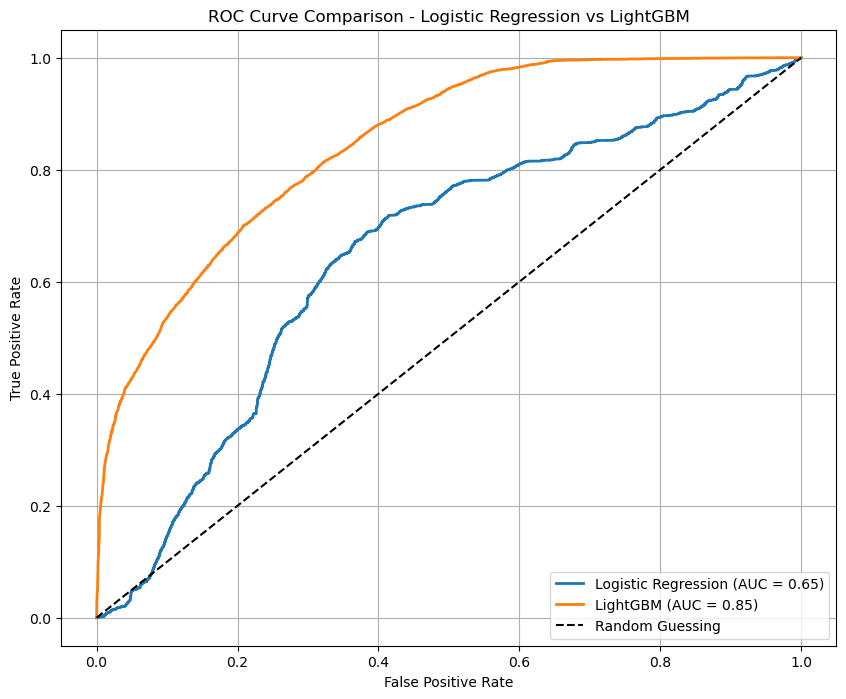

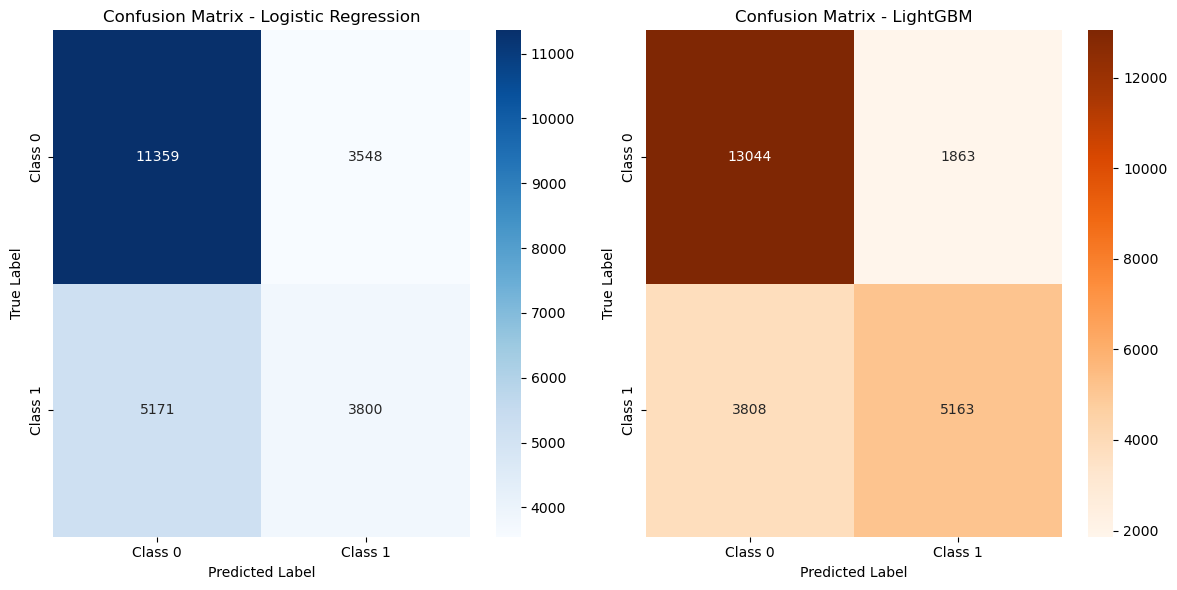

In [94]:
# Metrics for LightGBM
metrics_lgbm = {
    "Accuracy": accuracy_score(y_test, y_pred_lgbm),
    "Precision": precision_score(y_test, y_pred_lgbm),
    "Recall": recall_score(y_test, y_pred_lgbm),
    "F1-Score": f1_score(y_test, y_pred_lgbm),
    "AUC": roc_auc_score(y_test, y_proba_lgbm),
}

# Combine metrics into a DataFrame
comparison_lr_lgbm = pd.DataFrame([metrics_lr, metrics_lgbm], index=["Logistic Regression", "LightGBM"])
print("Comparison of Logistic Regression and LightGBM:")
print(comparison_lr_lgbm)

# Plot ROC Curves
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metrics_lr["AUC"]:.2f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {metrics_lgbm["AUC"]:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curve Comparison - Logistic Regression vs LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Confusion Matrices
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(12, 6))

# Logistic Regression
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# LightGBM
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="Oranges", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()
